####Импорты

In [1]:
!pip install yfinance
!pip install talib-binary
!pip install PyPortfolioOpt
!pip install apimoex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 9.5 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████

In [2]:
import yfinance as yf
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
from pypfopt import BlackLittermanModel, EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns, risk_models, plotting
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, plot_confusion_matrix, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression, SGDRegressor
from sklearn.svm import SVC,SVR, LinearSVC
import seaborn as sns
import talib as ta
from IPython.display import clear_output
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import requests
import apimoex
from scipy.stats import kurtosis
from sklearn.covariance import EmpiricalCovariance, LedoitWolf, ShrunkCovariance, OAS, empirical_covariance, ledoit_wolf, shrunk_covariance, oas
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
import plotly.graph_objects as go

####Обработка данных

#####Данные по доп индикаторам

идеи для фичей

- ключевая ставка +

- курс доллара +

- инфляция +

- сектор экономики +

- тех индикаторы +

- индекс рос рынка +

- другие макроэкономические показатели - 

- безработица -



In [3]:
#данные по индексу
index = pd.read_excel('/content/drive/MyDrive/ВКР/index.xlsx')
index = index.resample('W-Mon', label='left', closed = 'left', on='TRADEDATE').first()[['CLOSE']]
index['Close_index_pct_1'] = index['CLOSE'].shift(1)/index['CLOSE'].shift(2) - 1
index['Close_index_1'] = index['CLOSE'].shift(1)
index.reset_index(inplace = True)
# index.drop(columns = ['index'], inplace = True)
index.head()

,TRADEDATE,CLOSE,Close_index_pct_1,Close_index_1
0,2012-01-02,1444.76,NaN,NaN
1,2012-01-09,1448.36,NaN,1444.76
2,2012-01-16,1464.42,0.002492,1448.36
3,2012-01-23,1499.27,0.011088,1464.42
4,2012-01-30,1496.30,0.023798,1499.27


In [4]:
x = pd.read_excel('/content/drive/MyDrive/ВКР/RUONIA.xlsx')[['DT', 'ruo']]
x['Date'] = x['DT'].dt.to_period('W').apply(lambda r: r.start_time)
ruonia = pd.DataFrame(x.groupby('Date').first()['ruo'])
ruonia = ruonia.sort_values('Date').asfreq('W-Mon', 'pad').reset_index()
ruonia['ruo_1'] = ruonia['ruo'].shift()
ruonia['ruo_pct_1'] = ruonia['ruo_1']/ruonia['ruo_1'].shift() - 1
ruonia.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Date,ruo,ruo_1,ruo_pct_1
0,2010-01-11,4.21,NaN,NaN
1,2010-01-18,5.41,4.21,NaN
2,2010-01-25,3.99,5.41,0.285036
3,2010-02-01,3.46,3.99,-0.262477
4,2010-02-08,3.42,3.46,-0.132832


In [5]:
inf_rate = pd.read_excel('/content/drive/MyDrive/ВКР/Inflation_and_key_rate.xlsx', converters={'Дата':str})
inf_rate['Date'] = pd.to_datetime(inf_rate['Дата'], format='%m.%Y')
inf_rate['key_rate_1'] = inf_rate['Ключевая ставка, % годовых'].shift(-1)
inf_rate['inf_rate_1'] = inf_rate['Инфляция, % г/г'].shift(-1)
inf_rate.tail()

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Цель по инфляции,Date,key_rate_1,inf_rate_1
98,01.2014,5.5,6.07,NaN,2014-01-01,5.5,6.47
99,12.2013,5.5,6.47,NaN,2013-12-01,5.5,6.50
100,11.2013,5.5,6.50,NaN,2013-11-01,5.5,6.27
101,10.2013,5.5,6.27,NaN,2013-10-01,5.5,6.14
102,09.2013,5.5,6.14,NaN,2013-09-01,NaN,NaN


In [6]:
# данные по курсу USDRUB
dollar = yf.Ticker('RUB=X').history(period = 'max', interval = '1wk')
dollar['Open_dollar_pct_1'] = dollar['Open'].shift(1)/dollar['Open'].shift(2) - 1
dollar['Open_dollar_1'] = dollar['Open'].shift(1)
dollar.reset_index(inplace = True)
dollar.head()
# dollar.describe()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open_dollar_pct_1,Open_dollar_1
0,2003-12-01,29.730000,29.730000,29.629999,29.620001,0,0,0,NaN,NaN
1,2003-12-08,29.629999,29.629999,29.370001,29.400000,0,0,0,NaN,29.730000
2,2003-12-15,29.340000,29.379999,29.230000,29.280001,0,0,0,-0.003364,29.629999
3,2003-12-22,29.270000,29.350000,29.150000,29.299999,0,0,0,-0.009787,29.340000
4,2003-12-29,29.330000,29.440001,29.230000,29.230000,0,0,0,-0.002386,29.270000


In [7]:
# # данные по компаниям 
# ticker_info = pd.DataFrame()
# for ticker in tqdm(tickers_list):
#     ticker_object = yf.Ticker(ticker)

#     #convert info() output from dictionary to dataframe
#     temp = pd.DataFrame.from_dict(ticker_object.info, orient="index").T
#     ticker_info = ticker_info.append(temp)

# ticker_info
# from google.colab import files
# ticker_info.to_csv('ticker_info.csv')

# files.download('ticker_info.csv')

ticker_info = pd.read_csv('/content/drive/MyDrive/ВКР/ticker_info.csv')
ticker_info['symbol'] = ticker_info['symbol'].astype('str').apply(lambda x: x[:-3])


#####Финансовые индикаторы

In [ ]:
def ATR(data, period): #Average True range
  high_low = data['High'] - data['Low']
  high_cp = np.abs(data['High'] - data['Close'].shift())
  low_cp = np.abs(data['Low'] - data['Close'].shift())
  df = pd.concat([high_low, high_cp, low_cp], axis=1)
  true_range = np.max(df, axis=1)
  average_true_range = true_range.rolling(window=period,  closed  = 'left').mean()
  
  return average_true_range

In [ ]:
def RSI(data, period = 14, ema = False):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = data['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = period - 1, min_periods = period).mean().shift()
        ma_down = down.ewm(com = period - 1, min_periods = period).mean().shift()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = period,  closed  = 'left').mean()
        ma_down = down.rolling(window = period,  closed  = 'left').mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    
    return rsi

In [ ]:
#????
def ADX(data: pd.DataFrame, period: int):
    """
    Computes the ADX indicator.
    """
    
    df = data.copy()
    alpha = 1/period

    # TR
    df['H-L'] = df['High'] - df['Low']
    df['H-C'] = np.abs(df['High'] - df['Close'].shift(1))
    df['L-C'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
    del df['H-L'], df['H-C'], df['L-C']

    # ATR
    df['ATR'] = df['TR'].ewm(alpha=alpha, adjust=False).mean()

    # +-DX
    df['H-pH'] = df['High'] - df['High'].shift(1)
    df['pL-L'] = df['Low'].shift(1) - df['Low']
    df['+DX'] = np.where(
        (df['H-pH'] > df['pL-L']) & (df['H-pH']>0),
        df['H-pH'],
        0.0
    )
    df['-DX'] = np.where(
        (df['H-pH'] < df['pL-L']) & (df['pL-L']>0),
        df['pL-L'],
        0.0
    )
    del df['H-pH'], df['pL-L']

    # +- DMI
    df['S+DM'] = df['+DX'].ewm(alpha=alpha, adjust=False).mean()
    df['S-DM'] = df['-DX'].ewm(alpha=alpha, adjust=False).mean()
    df['+DMI'] = (df['S+DM']/df['ATR'])*100
    df['-DMI'] = (df['S-DM']/df['ATR'])*100
    del df['S+DM'], df['S-DM']

    # ADX
    df['DX'] = (np.abs(df['+DMI'] - df['-DMI'])/(df['+DMI'] + df['-DMI']))*100
    df['ADX'] = df['DX'].ewm(alpha=alpha, adjust=False).mean()
    del  df['TR'],  df['+DMI'], df['-DMI']

    return df

In [ ]:
def Stochastic(data, period, smoothing = 3, type = 'K'):
  df = pd.DataFrame()
  df['14-high'] = data['High'].rolling(period).max()
  df['14-low'] = data['Low'].rolling(period).min()
  df['%K'] = ((data['Close'] - df['14-low'])*100/(df['14-high'] - df['14-low']))
  df['%D'] = df['%K'].rolling(smoothing).mean()

  return df['%'+type].shift()

In [ ]:
def CCI(data, period): 
  df = pd.DataFrame()
  df['TP'] = (data['High'] + data['Low'] + data['Close']) / 3 
  df['sma'] = df['TP'].rolling(period).mean()
  df['mad'] = df['TP'].rolling(period).apply(lambda x: pd.Series(x).mad())
  df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
  
  return df['CCI'].shift()

In [ ]:
def Williams_R(high, low, close, period):
    highh = high.rolling(period).max() 
    lowl = low.rolling(period).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr

In [ ]:
stock = yf.Ticker('VTBR.ME')
stock = stock.history(period = 'max', interval = '1wk')
ATR(stock, 3)

Date
2010-03-01         NaN
2010-03-08         NaN
2010-03-15         NaN
2010-03-22    0.002508
2010-03-29    0.002508
                ...   
2022-04-04    0.004467
2022-04-11    0.006180
2022-04-18    0.005430
2022-04-25    0.003767
2022-04-29    0.002813
Length: 648, dtype: float64

In [ ]:
(np.sign(stock["Close"].diff()) * stock["Volume"]).fillna(0).cumsum().shift(1)

Date
2010-03-01             NaN
2010-03-08    0.000000e+00
2010-03-15    5.346364e+07
2010-03-22    5.346364e+07
2010-03-29    5.346364e+07
                  ...     
2022-04-04   -4.496198e+10
2022-04-11   -8.562494e+11
2022-04-18   -1.132058e+12
2022-04-25   -1.330970e+12
2022-04-29   -1.122838e+12
Length: 648, dtype: float64

In [ ]:
data = stock
high_low = data['High'] - data['Low']
high_cp = np.abs(data['High'] - data['Close'].shift())
low_cp = np.abs(data['Low'] - data['Close'].shift())
df = pd.concat([high_low, high_cp, low_cp], axis=1)
true_range = np.max(df, axis=1)
average_true_range = true_range.rolling(window=2,  closed  = 'left').mean()
pd.concat([df,true_range,average_true_range], axis=1)

,0,1,2,0,1
Date,,,,,
2010-03-01,0.002051,NaN,NaN,0.002051,NaN
2010-03-08,0.002735,0.001368,0.001368,0.002735,NaN
2010-03-15,0.002736,0.002052,0.000684,0.002736,0.002393
2010-03-22,0.002051,0.000684,0.001368,0.002051,0.002736
2010-03-29,0.002736,0.002052,0.000684,0.002736,0.002394
...,...,...,...,...,...
2022-04-04,0.005140,0.003860,0.001280,0.005140,0.006700
2022-04-11,0.003520,0.000680,0.002840,0.003520,0.006385
2022-04-18,0.002640,0.000370,0.002270,0.002640,0.004330


#####Загружаем данные по акциям (не выполнять)


In [ ]:
# тикеры на российском рынке
rm = pd.read_excel('/content/drive/MyDrive/ВКР/rates.xlsx')
rm = rm[rm['ISSUEDATE'] < '01.01.2014']
rm['ticker'] = rm['SECID'] #+'.ME'
tickers_list = rm['ticker'].to_list()

In [ ]:
ticker_market_data = pd.DataFrame()
for i in tqdm(tickers_list[:]):
  with requests.Session() as session:
    data = apimoex.get_market_candles(session,i, 7, start = '2013-01-01')
    stock = pd.DataFrame(data)
    try:
      stock.rename(columns = {'begin':'Date', 
                        'close':'Close', 
                        'open':'Open',
                        'high': 'High',
                        'low': 'Low',
                        'value': 'Volume'}, inplace = True)
      stock['Date'] = pd.to_datetime(stock['Date'])
      #заполним недели без торгов
      stock = stock[~stock.Date.duplicated(keep='first')]
      a = stock[['Date','Close']].set_index('Date').sort_values('Date').asfreq('W-Mon', 'pad').reset_index().merge(stock[['High','Open','Low', 'Date']], how = 'left', on = 'Date')
      a.Open.fillna(a.Close, inplace = True)
      a.High.fillna(a.Close, inplace = True)
      a.Low.fillna(a.Close, inplace = True)
      stock = a.merge(stock[['Volume', 'Date']], how = 'left', on = 'Date').fillna(0)
      #добавим признаки
      try:
        a = pd.DataFrame(apimoex.ISSClient(session, 'https://iss.moex.com/iss/securities/'+str(i)+'/dividends.json?').get()['dividends'])
        a['Date'] = pd.to_datetime(pd.DataFrame(a)['registryclosedate']).dt.to_period('W').apply(lambda r: r.start_time)
        stock = stock.merge(a[['Date', 'value']], how ='left', on = 'Date')
        stock.rename(columns = {'value': 'Dividends'}, inplace = True)
        stock.fillna(0, inplace=True)
      except:
        stock['Dividends'] = 0
      stock['Close_real'] = stock['Close']
      stock['Open_real'] = stock['Open']
      stock['High_real'] = stock['High']
      stock['Low_real'] = stock['Low']

      stock['Close'] = stock.Close + stock.Dividends.cumsum()
      stock['Open'] = stock.Open + stock.Dividends.cumsum()
      stock['High'] = stock.High + stock.Dividends.cumsum()
      stock['Low'] = stock.Low + stock.Dividends.cumsum()

      stock['Dividend_yield'] = stock['Dividends']/stock['Close']
      stock['Dividends_1'] = stock['Dividends'].shift()
      stock['Dividend_yield_1'] = stock['Dividends']/stock['Close'].shift(1)
      stock.set_index('Date', inplace=True)
      stock['AROONOSC_5'] = ta.AROONOSC(stock['High'],stock['Low'], 5).shift(1)
      stock['ATR_5'] = ATR(stock, 5)
      stock['CCI_5'] = CCI(stock, 5)
      stock['Stochastic_K_5'] = Stochastic(stock, 5)
      stock['RSI_5'] = RSI(stock, 5)
      stock['Momentum_5'] = stock['Close'].shift(1)/stock['Close'].shift(6)
      stock['Williams_R_5'] = Williams_R(stock['High'], stock['Low'], stock['Close'], 5).shift(1)
      stock['OBV_1'] = (np.sign(stock["Close"].diff()) * stock["Volume"]).fillna(0).cumsum().shift(1)

      stock['ATR_10'] = ATR(stock, 10)
      stock['CCI_10'] = CCI(stock, 10)
      stock['Stochastic_K_10'] = Stochastic(stock, 10)
      stock['RSI_10'] = RSI(stock, 10)
      stock['Momentum_10'] = stock['Close'].shift(1)/stock['Close'].shift(11)
      stock['Williams_R_10'] = Williams_R(stock['High'], stock['Low'], stock['Close'], 10).shift(1)

      stock['Volatility'] = stock['Close'].rolling(window=5,  closed  = 'left').var()
      stock['Kurtosis'] = stock['Close'].rolling(window=5,  closed  = 'left').kurt()
      stock['Skewness'] = stock['Close'].rolling(window=5,  closed  = 'left').skew()
      stock['Volume_rub_approx'] = stock['Volume']*stock['Close']
      stock['Volume_rub_approx_1'] = (stock['Volume']*stock['Close']).shift(1)

      stock['Close_diff'] = stock['Close'] - stock['Close'].shift() 
      stock['Close_diff_1'] = stock['Close_diff'].shift(1)
      stock['Close_diff_2'] = stock['Close_diff'].shift(2)
      stock['Close_diff_3'] = stock['Close_diff'].shift(3)
      stock['Close_diff_4'] = stock['Close_diff'].shift(4)
      stock['Close_diff_5'] = stock['Close_diff'].shift(5)

      stock['Close_pct'] = stock['Close']/stock['Close'].shift() - 1
      stock['Close_pct_1'] = stock['Close_pct'].shift(1)
      stock['Close_pct_2'] = stock['Close_pct'].shift(2)
      stock['Close_pct_3'] = stock['Close_pct'].shift(3)
      stock['Close_pct_4'] = stock['Close_pct'].shift(4)
      stock['Close_pct_5'] = stock['Close_pct'].shift(5)

      stock['Close_1'] = stock['Close'].shift(1)
      stock['Close_2'] = stock['Close'].shift(2)
      stock['Close_3'] = stock['Close'].shift(3)
      stock['Close_4'] = stock['Close'].shift(4)
      stock['Close_5'] = stock['Close'].shift(5)

      stock['Close_5_max'] = stock['Close'].rolling(window=5,  closed  = 'left').max()/stock['Close'].shift()
      stock['Close_10_max'] = stock['Close'].rolling(window=10,  closed  = 'left').max()/stock['Close'].shift()
      # stock['Close_30_max'] = stock['Close'].rolling(window=30, min_periods = 10).max()/stock['Close']
      stock['Close_MA5'] = stock['Close'].rolling(window=5,  closed  = 'left').mean()
      stock['Close_MA10'] = stock['Close'].rolling(window=10,  closed  = 'left').mean()
      # stock['Close_MA30'] = stock['Close'].rolling(window=30, min_periods = 10).mean()
      stock['ticker'] = i
      stock['name'] = rm[rm['ticker'] == i]['NAME'].values[0]
      stock.reset_index(inplace = True)
      ticker_market_data = ticker_market_data.append(stock)
      print(i,stock.shape[0])
    except:
      print(i)
# ticker_market_data.drop(columns = ['Adj Close'], inplace = True)
# hist['year_month'] = pd.to_datetime(hist.index.values).to_period('D')
# russian_market[i+'.ME'] = (hist.groupby('year_month')['Close'].mean())
clear_output()

In [ ]:
from google.colab import files
ticker_market_data.to_excel('ticker_market_data.xlsx')

files.download('ticker_market_data.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####Обогащаем данными по рынку

In [ ]:
ticker_market_data = pd.read_excel('/content/drive/MyDrive/ВКР/ticker_market_data.xlsx')
ticker_market_data.drop(columns = 'Unnamed: 0', inplace = True)
ticker_market_data.head()

,Date,Close,High,Open,Low,Volume,Dividends,Close_real,Open_real,High_real,...,Close_2,Close_3,Close_4,Close_5,Close_5_max,Close_10_max,Close_MA5,Close_MA10,ticker,name
0,2013-01-07,75.44,76.0,75.50,74.10,2244771.0,0.0,75.44,75.50,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABRD,Абрау-Дюрсо ПАО ао
1,2013-01-14,77.95,78.0,75.74,75.45,4846019.0,0.0,77.95,75.74,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABRD,Абрау-Дюрсо ПАО ао
2,2013-01-21,77.80,77.8,77.75,75.30,8378796.0,0.0,77.80,77.75,77.8,...,75.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABRD,Абрау-Дюрсо ПАО ао
3,2013-01-28,77.60,78.2,77.88,77.07,3745765.0,0.0,77.60,77.88,78.2,...,77.95,75.44,NaN,NaN,NaN,NaN,NaN,NaN,ABRD,Абрау-Дюрсо ПАО ао
4,2013-02-04,78.50,78.5,77.63,77.00,3181340.0,0.0,78.50,77.63,78.5,...,77.80,77.95,75.44,NaN,NaN,NaN,NaN,NaN,ABRD,Абрау-Дюрсо ПАО ао


In [ ]:
selected_ticker = ticker_market_data
print(selected_ticker.shape)
# берем с всех, у кого есть наблюдения с 2014 года по 2022
selected_ticker = selected_ticker.loc[selected_ticker['ticker'].isin(
    pd.DataFrame(selected_ticker.groupby('ticker')['Date'].min().sort_values(ascending=False))[
    pd.DataFrame(selected_ticker.groupby('ticker')['Date'].min().sort_values(ascending=False))['Date'] <=
    '01.01.2014'].index)]
print(selected_ticker.shape)
selected_ticker = selected_ticker.loc[selected_ticker['ticker'].isin(
    pd.DataFrame(selected_ticker.groupby('ticker')['Date'].max().sort_values(ascending=False))[
    pd.DataFrame(selected_ticker.groupby('ticker')['Date'].max().sort_values(ascending=False))['Date'] > 
    '01.01.2022'].index)]
print(selected_ticker.shape)
# # берем с всех, у кого более 500 наблюдений за это время
# # print(selected_ticker.groupby('ticker')['Date'].size().sort_values().head(50))
# selected_ticker = selected_ticker[selected_ticker.name.isin(
#         selected_ticker.groupby('name')['Date'].size().sort_values().where((selected_ticker.groupby('name')['Date'].size().sort_values() > 0)).dropna().index)]
# print(selected_ticker.shape)
# selected_ticker.groupby('name')['Date'].max().sort_values(ascending=False)
# оставляем только нужные наблюдения
selected_ticker = selected_ticker[(selected_ticker['Date'] < '01.01.2022') & (selected_ticker['Date'] > '01.01.2014')]
print(selected_ticker.shape)
# #берем 30 крупнейших по медианному объему торгов
selected_ticker = selected_ticker.loc[selected_ticker['ticker'].isin(selected_ticker.groupby('ticker')['Volume_rub_approx'].mean().sort_values(ascending=False).head(30).index)]
print(selected_ticker.shape)
selected_ticker = selected_ticker.dropna(axis = 0)
print(selected_ticker.shape)
selected_ticker['Month'] = selected_ticker['Date'].dt.to_period('M').apply(lambda r: r.start_time)
#почистим дубли
selected_ticker.set_index(['Date', 'ticker'], inplace = True)
selected_ticker = selected_ticker[~selected_ticker.index.duplicated(keep='first')]
selected_ticker.reset_index(inplace = True)
print(selected_ticker.shape)
selected_ticker.groupby('ticker')['Volume_rub_approx'].mean().sort_values(ascending=False)

(76470, 56)
(75563, 56)
(72371, 56)
(62551, 56)
(12511, 56)
(12511, 56)
(12510, 57)


ticker
GMKN    3.786812e+14
LKOH    1.179747e+14
MGNT    6.709979e+13
PLZL    5.117857e+13
SBER    1.259103e+13
GAZP    8.990045e+12
CHMF    6.742288e+12
NVTK    5.843122e+12
ROSN    4.718552e+12
TATN    3.697232e+12
PHOR    3.491806e+12
VSMO    1.324693e+12
MTSS    1.240209e+12
BANE    1.063634e+12
AKRN    1.037448e+12
NLMK    9.015097e+11
ALRS    6.954327e+11
MOEX    6.555464e+11
LNZL    5.631047e+11
PIKK    5.148378e+11
AFLT    4.137203e+11
SIBN    3.975265e+11
MVID    3.004698e+11
KOGK    2.441331e+11
LSRG    2.156547e+11
MAGN    2.004325e+11
SNGS    1.972330e+11
RASP    1.348504e+11
MTLR    1.171386e+11
RTKM    1.050565e+11
Name: Volume_rub_approx, dtype: float64

In [ ]:
selected_ticker = selected_ticker.merge(ticker_info[['sector', 'symbol']],
                                        how = 'left',
                                        left_on='ticker',
                                        right_on='symbol').drop(columns = 'symbol')
selected_ticker = selected_ticker.merge(pd.get_dummies(selected_ticker[['sector']]),
                                        how = 'left',
                                        right_index = True,
                                        left_index = True).drop(columns = 'sector')

selected_ticker = selected_ticker.merge(dollar[['Open_dollar_pct_1', 'Date']],
                                        how = 'left',
                                        on = 'Date')    
selected_ticker = selected_ticker.merge(index[['Close_index_pct_1', 'TRADEDATE']],
                                        how = 'left',
                                        left_on = 'Date', right_on = 'TRADEDATE') 
selected_ticker.drop(columns = ['TRADEDATE'], inplace = True)  

selected_ticker = selected_ticker.merge(ruonia[['ruo_1','ruo_pct_1', 'Date']],
                                        how = 'left',
                                        on = 'Date') 
selected_ticker = selected_ticker.merge(inf_rate[['Date', 'key_rate_1', 'inf_rate_1']],
                                        how = 'left',
                                        left_on = 'Month',
                                        right_on = 'Date').drop(columns = 'Date_y')
selected_ticker.rename(columns = {'Date_x':'Date'}, inplace = True)
print(selected_ticker.shape)

selected_ticker['target'] = 0
selected_ticker.loc[selected_ticker.Close_pct > 0, 'target'] = 1
selected_ticker['naive_pred'] = 0
selected_ticker.loc[selected_ticker.Close_pct_1 > 0, 'naive_pred'] = 1
selected_ticker.target.value_counts()
selected_ticker = selected_ticker.dropna(axis = 0)
selected_ticker.reset_index(inplace = True)
print(selected_ticker.shape)

rank = pd.concat([selected_ticker['Date'].drop_duplicates(),
           pd.DataFrame(selected_ticker['Date'].drop_duplicates().rank(method='first'))],
           axis = 1 )
rank.columns = ['Date', 'rank']
rank
selected_ticker = selected_ticker.merge(rank, how = 'left', left_on = 'Date',   right_on = 'Date')   
selected_ticker.drop(columns ='index', inplace =True)
selected_ticker[selected_ticker['rank'] == 1].head()

(12510, 71)
(12510, 74)


,Date,ticker,Close,High,Open,Low,Volume,Dividends,Close_real,Open_real,...,sector_Real Estate,Open_dollar_pct_1,Close_index_pct_1,ruo_1,ruo_pct_1,key_rate_1,inf_rate_1,target,naive_pred,rank
0,2014-01-06,AFLT,82.83,84.830,83.960,82.100,9.531951e+08,0.0,82.83,83.960,...,0,-0.012932,-0.002262,6.24,-0.04,5.5,6.47,0,1,1.0
417,2014-01-06,AKRN,1112.00,1135.500,1130.000,1085.100,4.184692e+07,0.0,1112.00,1130.000,...,0,-0.012932,-0.002262,6.24,-0.04,5.5,6.47,0,1,1.0
834,2014-01-06,ALRS,33.20,35.399,35.399,32.201,2.564785e+08,0.0,33.20,35.399,...,0,-0.012932,-0.002262,6.24,-0.04,5.5,6.47,0,1,1.0
1251,2014-01-06,BANE,2216.90,2218.900,2214.900,2173.100,6.464103e+07,0.0,2017.90,2015.900,...,0,-0.012932,-0.002262,6.24,-0.04,5.5,6.47,1,1,1.0
1668,2014-01-06,CHMF,309.94,321.240,320.040,305.440,1.371369e+09,0.0,305.90,316.000,...,0,-0.012932,-0.002262,6.24,-0.04,5.5,6.47,0,1,1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


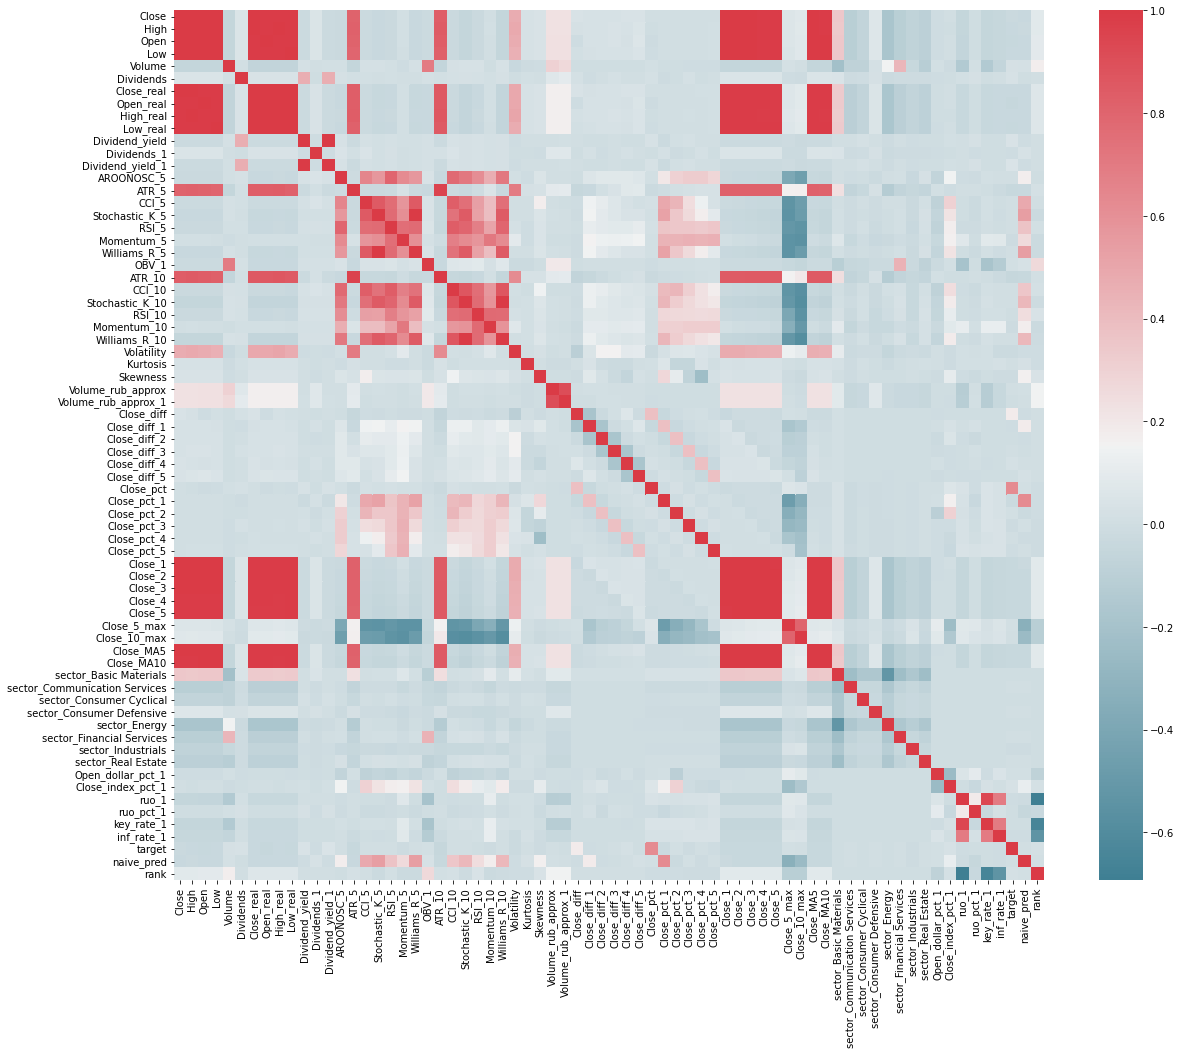

In [ ]:
import seaborn as sns

X_col = selected_ticker.columns.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Close_diff', 'Volume',
       'ticker', 'name','target', 'rank', 'Close_pct','Volume_rub_approx', 'naive_pred',
       'Dividend_yield', 'Month', 'Dividends_1'])
X_col

f, ax = plt.subplots(figsize=(20, 16))
corr = selected_ticker.corr()
corr = corr
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [ ]:
selected_ticker[['ticker', 'name']].drop_duplicates().to_latex(index = False)

'\\begin{tabular}{ll}\n\\toprule\nticker &                           name \\\\\n\\midrule\n  AFLT &   Аэрофлот-росс.авиалин(ПАО)ао \\\\\n  AKRN &                   Акрон ПАО ао \\\\\n  ALRS &                  АЛРОСА ПАО ао \\\\\n  BANE &                Башнефть АНК ао \\\\\n  CHMF &             Северсталь (ПАО)ао \\\\\n  GAZP &             "Газпром" (ПАО) ао \\\\\n  GMKN &        ГМК "Нор.Никель" ПАО ао \\\\\n  KOGK &        Коршуновский ГОК ПАО ао \\\\\n  LKOH &           НК ЛУКОЙЛ (ПАО) - ао \\\\\n  LNZL &             "Лензолото" ПАО ао \\\\\n  LSRG &              Группа ЛСР ПАО ао \\\\\n  MAGN & "Магнитогорск.мет.комб" ПАО ао \\\\\n  MGNT &                "Магнит" ПАО ао \\\\\n  MOEX &           ПАО Московская Биржа \\\\\n  MTLR &                   Мечел ПАО ао \\\\\n  MTSS &   Мобильные ТелеСистемы ПАО ао \\\\\n  MVID &               "М.видео" ПАО ао \\\\\n  NLMK &                  ПАО "НЛМК" ао \\\\\n  NVTK &               ПАО "НОВАТЭК" ао \\\\\n  PHOR &                 ФосАгро ПА

In [ ]:
selected_ticker[['Close', 'Close_pct','ticker']].groupby('ticker').mean().sort_values('Close')

,Close,Close_pct
ticker,,
SNGS,34.437988,0.002016
MAGN,43.303458,0.006989
MTLR,85.428201,0.006299
ALRS,97.741235,0.004544
RASP,102.003405,0.008345
RTKM,102.054523,0.000633
AFLT,111.296280,0.001268
MOEX,131.127218,0.003323
NLMK,162.198909,0.004982


In [ ]:
selected_ticker

,Date,ticker,Close,High,Open,Low,Volume,Dividends,Close_real,Open_real,...,sector_Real Estate,Open_dollar_pct_1,Close_index_pct_1,ruo_1,ruo_pct_1,key_rate_1,inf_rate_1,target,naive_pred,rank
0,2014-01-06,AFLT,82.83,84.83,83.96,82.10,9.531951e+08,0.0,82.83,83.96,...,0,-0.012932,-0.002262,6.24,-0.040000,5.5,6.47,0,1,1.0
1,2014-01-13,AFLT,84.25,99.30,83.25,82.09,2.430875e+09,0.0,84.25,83.25,...,0,0.019187,-0.025218,5.84,-0.064103,5.5,6.47,1,0,2.0
2,2014-01-20,AFLT,78.70,86.20,84.25,76.02,2.472036e+09,0.0,78.70,84.25,...,0,-0.004804,0.007782,5.94,0.017123,5.5,6.47,0,1,3.0
3,2014-01-27,AFLT,83.00,84.86,77.70,77.70,1.435716e+09,0.0,83.00,77.70,...,0,0.016747,0.012047,6.10,0.026936,5.5,6.47,1,0,4.0
4,2014-02-03,AFLT,79.50,83.98,83.53,75.00,2.108259e+09,0.0,79.50,83.53,...,0,0.028409,-0.011455,6.29,0.031148,5.5,6.07,0,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12505,2021-11-29,VSMO,51447.83,52127.83,51887.83,49147.83,1.946880e+08,0.0,45420.00,45860.00,...,0,0.010402,-0.063449,7.33,-0.008119,7.5,8.13,0,0,413.0
12506,2021-12-06,VSMO,50027.83,54327.83,51027.83,49887.83,2.653414e+08,0.0,44000.00,45000.00,...,0,0.023135,0.001748,7.16,-0.023192,7.5,8.40,0,0,414.0
12507,2021-12-13,VSMO,54067.83,54527.83,50547.83,50027.83,4.139013e+08,0.0,48040.00,44520.00,...,0,-0.016569,-0.017899,7.45,0.040503,7.5,8.40,1,0,415.0
12508,2021-12-20,VSMO,52027.83,54327.83,54047.83,50427.83,1.664189e+08,0.0,46000.00,48020.00,...,0,-0.007870,-0.050337,7.50,0.006711,7.5,8.40,0,1,416.0


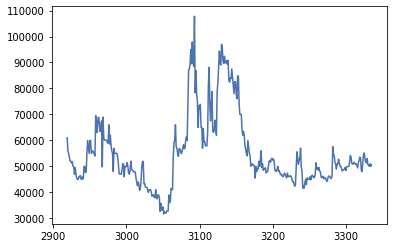

In [ ]:
plt.plot(selected_ticker[selected_ticker['ticker'] == 'KOGK']['Close'])
plt.show()

####Пробуем чето предсказать (не выполнять)


In [ ]:
selected_ticker.columns

Index(['Date', 'ticker', 'Close', 'High', 'Open', 'Low', 'Volume', 'Dividends',
       'Close_real', 'Open_real', 'High_real', 'Low_real', 'Dividend_yield',
       'Dividends_1', 'Dividend_yield_1', 'AROONOSC_5', 'ATR_5', 'CCI_5',
       'Stochastic_K_5', 'RSI_5', 'Momentum_5', 'Williams_R_5', 'OBV_1',
       'ATR_10', 'CCI_10', 'Stochastic_K_10', 'RSI_10', 'Momentum_10',
       'Williams_R_10', 'Volatility', 'Kurtosis', 'Skewness',
       'Volume_rub_approx', 'Volume_rub_approx_1', 'Close_diff',
       'Close_diff_1', 'Close_diff_2', 'Close_diff_3', 'Close_diff_4',
       'Close_diff_5', 'Close_pct', 'Close_pct_1', 'Close_pct_2',
       'Close_pct_3', 'Close_pct_4', 'Close_pct_5', 'Close_1', 'Close_2',
       'Close_3', 'Close_4', 'Close_5', 'Close_5_max', 'Close_10_max',
       'Close_MA5', 'Close_MA10', 'name', 'Month', 'sector_Basic Materials',
       'sector_Communication Services', 'sector_Consumer Cyclical',
       'sector_Consumer Defensive', 'sector_Energy',
       'sector_Fin

In [ ]:
#предсказывалка с движущимся окном
data_train = selected_ticker#[selected_ticker['ticker'] == 'AFLT.ME']
min_max_scaler = MinMaxScaler()
data_train[X_col] = min_max_scaler.fit_transform(data_train[X_col])
standard_scaler = StandardScaler()
data_train[X_col] = standard_scaler.fit_transform(data_train[X_col])

res = []
weeks = [50]
start_rank = max(weeks)
for j in tqdm(weeks):
  pred = []
  prob = []
  test = []
  tickers_test = []
  for rank in tqdm(range(start_rank-j, int(max(data_train['rank'])-450)-j,1)):
    # try:
      num_weeks = j
      X_train = data_train[(data_train['rank'] < rank + num_weeks+1) & (data_train['rank'] > rank )][X_col]
      # print(X_train.shape)
      X_test = data_train[data_train['rank'] == rank + num_weeks+1][X_col]
      # print(X_test.shape)
      # y_train = data_train[(data_train['rank'] < rank + num_weeks+1) & (data_train['rank'] > rank )]['target']
      # y_test = data_train[data_train['rank'] == rank + num_weeks+1]['target']
      # print(y_test.values)
      y_train = data_train[(data_train['rank'] < rank + num_weeks+1) & (data_train['rank'] > rank )]['Close']
      y_test = data_train[data_train['rank'] == rank + num_weeks+1]['Close']     
      tickers_test.extend(data_train[data_train['rank'] == rank + num_weeks+1]['ticker'])
      # clf = LogisticRegression()
      # clf = RandomForestClassifier(n_estimators=300)
      clf = RandomForestRegressor(n_estimators=100)
      # clf = SVC(probability=True)
      clf.fit(X_train, y_train)
      pred.extend(clf.predict(X_test))
      # prob.extend(clf.predict_proba(X_test))
      test.extend(y_test.values)
      # print(accuracy_score(test, pred))
      print(mean_absolute_percentage_error(test, pred))
      plt.barh(X_train.columns, clf.feature_importances_)
    # except:
    #   pass
  # res.append([j, accuracy_score(test, pred), recall_score(test, pred), precision_score(test, pred), f1_score(test, pred)])
  # print(accuracy_score(test, pred), j)
  print(mean_absolute_percentage_error(test, pred))
  ee = pd.DataFrame({'ticker':tickers_test, 'true': test, 'pred': pred, 
                    #  'prob': np.array(prob)[:, :1].reshape(-1)
                     })
  ee['success_flg'] = (ee['true'] == ee['pred']).astype(int)
  print((ee.groupby('ticker')['success_flg'].sum()/ee.groupby('ticker')['success_flg'].count()).sort_values(ascending=False))

In [ ]:
def train_pred_moving_window(X, y, model, model_type = 'clf', rank_start, rank_end)

#### Функции обучение, предсказание, портфель и метрики

In [ ]:
def train_pred(data_train,
                      model,
                      X_col,
                      y_col,
                      model_type = 'clf',
                      train_type = 'simple',
                      split_rank = 10,
                      prob = False,
                      feature_importance = False):
  output = dict()
  min_max_scaler = MinMaxScaler()
  min_max_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
  data_train[X_col] = min_max_scaler.transform(data_train[X_col])
  standard_scaler = StandardScaler()
  standard_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
  data_train[X_col] = standard_scaler.transform(data_train[X_col])

  X_train = data_train[data_train['rank'] < split_rank][X_col]
  X_test = data_train[data_train['rank'] >= split_rank][X_col]
  y_train = data_train[data_train['rank'] < split_rank][y_col]
  y_test = data_train[data_train['rank'] >= split_rank][y_col] 
  clf = model
  clf.fit(X_train, y_train)
  if model_type == 'clf':
      res = {'ticker':data_train[data_train['rank'] >= split_rank]['ticker'].values,
              'Date':data_train[data_train['rank'] >= split_rank]['Date'].values, 
              'pred':clf.predict(X_test).astype(float), 
              'true': np.array(y_test).reshape(-1).astype(float)}
      metrics = {
          'accuracy': accuracy_score(res['true'], res['pred']),
          'recall': recall_score(res['true'],res['pred']),
          'precision': precision_score(res['true'],res['pred']),
          'f1_score': f1_score(res['true'],res['pred']),
          'confusion_matrix': confusion_matrix(res['true'], res['pred']) 
          }
      if feature_importance:
        output['feature_importances']  = {'feature_name':X_train.columns,'feature_importance':clf.feature_importances_}
      if prob:
        res['prob'] = clf.predict_proba(X_test)[:, :1].reshape(-1)
        metrics['roc_auc_score'] = roc_auc_score(res['true'], res['prob'])
  if model_type == 'reg':
      res = {'ticker':data_train[data_train['rank'] >= split_rank]['ticker'].values,
              'Date':data_train[data_train['rank'] >= split_rank]['Date'].values, 
              'reg_pred' : clf.predict(X_test), 
              'reg_true' : np.array(y_test).reshape(-1)}
      if  y_col == 'Close':
        a = [np.nan]
        a.extend(np.sign(np.diff(np.array(res['reg_true']))))
        res['true'] = np.array([0 if  x < 0 else x for x in a]).astype(float)
        a = [np.nan]
        a.extend(np.sign(np.diff(np.array(res['reg_pred']))))
        res['pred'] = np.array([0 if  x < 0 else x for x in a]).astype(float)
      if  y_col == 'Close_pct' or y_col == 'Close_diff':
        a = []
        a.extend(np.sign(np.array(res['reg_true'])))
        res['true'] = np.array([0 if  x < 0 else x for x in a]).astype(float)
        a = []
        a.extend(np.sign(np.array(res['reg_pred'])))
        res['pred'] = np.array([0 if  x < 0 else x for x in a]).astype(float)
      metrics = {
          'accuracy': accuracy_score(res['true'][1:], res['pred'][1:]),
          'recall': recall_score(res['true'][1:],res['pred'][1:]),
          'precision': precision_score(res['true'][1:],res['pred'][1:]),
          'f1_score': f1_score(res['true'][1:],res['pred'][1:]),
          'confusion_matrix': confusion_matrix(res['true'][1:], res['pred'][1:]),
          'MAE': mean_absolute_error(res['reg_true'], res['reg_pred']), 
          'MSE':mean_squared_error(res['reg_true'], res['reg_pred']), 
          'MAPE':mean_absolute_percentage_error(res['reg_true'], res['reg_pred'])
          }
      if feature_importance:
        output['feature_importances']  = {'feature_name':X_train.columns,'feature_importance':clf.feature_importances_}
    
  output['test_data'] = res
  output['metrics'] = metrics 

  return output

In [ ]:
# def weights(market, return_method, cov_method, bounds):
#   # Calculate expected returns and sample covariance
#   x = market
#   mu = expected_returns.return_model(x, method=return_method)
#   S = risk_models.risk_matrix(x, method=cov_method)
#   ef = EfficientFrontier(mu, S, weight_bounds=bounds)
#   raw_weights = ef.min_volatility()
#   cleaned_weights = ef.clean_weights()
#   return dict(cleaned_weights)

In [ ]:
def max_drawdown(dohod):
  listok = []
  max = 0
  for i in range(len(dohod)):
    if max < dohod[i]:
      max = dohod[i]
      listok.append(dohod[i])
    else:
      listok.append(max)
  ind = list(np.array(dohod) - np.array(listok)).index(np.min(np.array(dohod) - np.array(listok)))
  return (np.max(np.array(dohod[:ind])) -  dohod[ind])/np.max(np.array(dohod[:ind]))*100

In [ ]:
def total_return(dohod):
  return (dohod[-1] -dohod[0]) /dohod[0]

In [ ]:
def total_volatility(ret):
  return np.sum((ret -ret.mean())**2)/len(ret)

In [ ]:
def turnover(market_weights,market, ind):
  b = np.array(market_weights.loc[ind].iloc[1:])
  a = ((np.array(market_weights.loc[ind].iloc[:-1]) * np.array(market.loc[ind].iloc[1:]))/np.sum(np.array(market_weights.loc[ind].iloc[:-1]) * np.array(market.loc[ind].iloc[1:]), axis=1).reshape((market_weights.loc[ind].iloc[1:].shape[0],1)))
  return np.sum(np.abs(a - b))/np.abs(a - b).shape[0]

In [ ]:
def ledoit_wolf_constant_correlation(X):
    t, n = np.shape(X)
    S = empirical_covariance(X, assume_centered=True)
    var = np.diag(S).reshape(-1, 1)
    std = np.sqrt(var)
    _var = np.tile(var, (n,))
    _std = np.tile(std, (n,))
    r_bar = (np.sum(S / (_std * _std.T)) - n) / (n * (n - 1))
    F = r_bar * (_std * _std.T)
    F[np.eye(n) == 1] = var.reshape(-1)

    # Estimate pi
    Xm = X - X.mean(axis=0)
    y = Xm ** 2
    pi_mat = np.dot(y.T, y) / t - 2 * np.dot(Xm.T, Xm) * S / t + S ** 2
    pi_hat = np.sum(pi_mat)

    # Theta matrix, expanded term by term
    term1 = np.dot((Xm ** 3).T, Xm) / t
    help_ = np.dot(Xm.T, Xm) / t
    help_diag = np.diag(help_)
    term2 = np.tile(help_diag, (n, 1)).T * S
    term3 = help_ * _var
    term4 = _var * S
    theta_mat = term1 - term2 - term3 + term4
    theta_mat[np.eye(n) == 1] = np.zeros(n)
    rho_hat = sum(np.diag(pi_mat)) + r_bar * np.sum(
        np.dot((1 / std), std.T) * theta_mat
    )

    # Estimate gamma
    gamma_hat = np.linalg.norm(S - F, "fro") ** 2

    # Compute shrinkage constant
    kappa_hat = (pi_hat - rho_hat) / gamma_hat
    delta = max(0.0, min(1.0, kappa_hat / t))

    # Compute shrunk covariance matrix
    shrunk_cov = delta * F + (1 - delta) * S
    return shrunk_cov


In [ ]:
def weights(market, return_method, cov_method, bounds):
  # Calculate expected returns and sample covariance
  X = market.copy()
  mu = expected_returns.return_model(X, method=return_method)
  if cov_method == "exp_cov":
    lamda = 0.5
    X = X*np.power(np.expand_dims(np.power(np.array(lamda),np.arange(X.shape[0])), axis=0).reshape(-1,1),  0.5)
    S = np.dot(X.T, X) / X.shape[0] *(1-lamda)
  if cov_method == "sample_cov":
    S = empirical_covariance(X, assume_centered=True)
  if cov_method == "ledoit_wolf_constant_variance":
    S = ledoit_wolf(X, assume_centered=True)[0]
  if cov_method == "oracle_approximating":
    S = oas(X, assume_centered=True)[0]
  if cov_method == "ledoit_wolf_constant_correlation":
    S = ledoit_wolf_constant_correlation(X)
  ef = EfficientFrontier(mu, S, weight_bounds=bounds)
  raw_weights = ef.min_volatility()
  cleaned_weights = ef.clean_weights()
  return dict(cleaned_weights)

####Обучение и предсказание

#####X_cols

In [ ]:
selected_ticker.columns

Index(['Date', 'ticker', 'Close', 'High', 'Open', 'Low', 'Volume', 'Dividends',
       'Close_real', 'Open_real', 'High_real', 'Low_real', 'Dividend_yield',
       'Dividends_1', 'Dividend_yield_1', 'AROONOSC_5', 'ATR_5', 'CCI_5',
       'Stochastic_K_5', 'RSI_5', 'Momentum_5', 'Williams_R_5', 'OBV_1',
       'ATR_10', 'CCI_10', 'Stochastic_K_10', 'RSI_10', 'Momentum_10',
       'Williams_R_10', 'Volatility', 'Kurtosis', 'Skewness',
       'Volume_rub_approx', 'Volume_rub_approx_1', 'Close_diff',
       'Close_diff_1', 'Close_diff_2', 'Close_diff_3', 'Close_diff_4',
       'Close_diff_5', 'Close_pct', 'Close_pct_1', 'Close_pct_2',
       'Close_pct_3', 'Close_pct_4', 'Close_pct_5', 'Close_1', 'Close_2',
       'Close_3', 'Close_4', 'Close_5', 'Close_5_max', 'Close_10_max',
       'Close_MA5', 'Close_MA10', 'name', 'Month', 'sector_Basic Materials',
       'sector_Communication Services', 'sector_Consumer Cyclical',
       'sector_Consumer Defensive', 'sector_Energy',
       'sector_Fin

In [ ]:
X_col = selected_ticker.columns.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Close_diff', 'Volume','Dividends', 'Close_real', 'Open_real', 'High_real', 'Low_real',
       'Dividend_yield_1',
       'ticker', 'name','target', 'rank', 'Close_pct','Volume_rub_approx', 'naive_pred',
       'Dividend_yield', 'Month', 'Dividends_1'])
X_col_close = selected_ticker.columns.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Close_diff', 'Volume','Dividends', 'Close_real', 'Open_real', 'High_real', 'Low_real',
       'Dividend_yield_1',
       'ticker', 'name','target', 'rank', 'Close_pct','Volume_rub_approx', 'naive_pred',
       'Dividend_yield', 'Month', 'Dividends_1','Close_diff_1', 'Close_diff_2', 'Close_diff_3',
       'Close_diff_4', 'Close_diff_5', 'Close_pct_1', 'Close_pct_2',
       'Close_pct_3', 'Close_pct_4', 'Close_pct_5', 'AROONOSC_5', 'ATR_5', 'CCI_5',
       'Stochastic_K_5', 'RSI_5', 'Momentum_5', 'Williams_R_5'])
X_col_clf = selected_ticker.columns.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Close_diff', 'Volume','Dividends', 'Close_real', 'Open_real', 'High_real', 'Low_real',
       'Dividend_yield_1',
       'ticker', 'name','target', 'rank', 'Close_pct','Volume_rub_approx', 'naive_pred',
       'Dividend_yield', 'Month', 'Dividends_1','Close_diff_1', 'Close_diff_2', 'Close_diff_3','Close_1',
       'Close_2', 'Close_3', 'Close_4', 'Close_5',
       'Close_diff_4', 'Close_diff_5', 'AROONOSC_5', 'ATR_5', 'CCI_5',
       'Stochastic_K_5', 'RSI_5', 'Momentum_5', 'Williams_R_5'])
X_col_diff = selected_ticker.columns.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Close_diff', 'Volume','Dividends', 'Close_real', 'Open_real', 'High_real', 'Low_real',
       'Dividend_yield_1',
       'ticker', 'name','target', 'rank', 'Close_pct','Volume_rub_approx', 'naive_pred',
       'Dividend_yield', 'Month', 'Dividends_1', 'Close_pct_1', 'Close_pct_2',
       'Close_pct_3', 'Close_pct_4', 'Close_pct_5','Close_1',
       'Close_2', 'Close_3', 'Close_4', 'Close_5', 'AROONOSC_5', 'ATR_5', 'CCI_5',
       'Stochastic_K_5', 'RSI_5', 'Momentum_5', 'Williams_R_5'])
X_col_pct = selected_ticker.columns.drop(['Date', 'Open', 'High', 'Low', 
                                          'Close', 'Close_diff',
                                          'Volume','Dividends', 'Close_real', 'Open_real', 'High_real', 'Low_real',
       'Dividend_yield_1',
       'ticker', 'name','target', 'rank', 'Close_pct','Volume_rub_approx', 'naive_pred',
       'Dividend_yield', 'Month', 'Dividends_1', 'Close_diff_1', 'Close_diff_2', 'Close_diff_3','Close_diff_4', 'Close_diff_5'
        ,'Close_1','Close_2', 'Close_3', 'Close_4', 'Close_5', 'AROONOSC_5', 'ATR_5', 'CCI_5',
       'Stochastic_K_5', 'RSI_5', 'Momentum_5', 'Williams_R_5'])

X_col_pct

Index(['OBV_1', 'ATR_10', 'CCI_10', 'Stochastic_K_10', 'RSI_10', 'Momentum_10',
       'Williams_R_10', 'Volatility', 'Kurtosis', 'Skewness',
       'Volume_rub_approx_1', 'Close_pct_1', 'Close_pct_2', 'Close_pct_3',
       'Close_pct_4', 'Close_pct_5', 'Close_5_max', 'Close_10_max',
       'Close_MA5', 'Close_MA10', 'sector_Basic Materials',
       'sector_Communication Services', 'sector_Consumer Cyclical',
       'sector_Consumer Defensive', 'sector_Energy',
       'sector_Financial Services', 'sector_Industrials', 'sector_Real Estate',
       'Open_dollar_pct_1', 'Close_index_pct_1', 'ruo_1', 'ruo_pct_1',
       'key_rate_1', 'inf_rate_1'],
      dtype='object')

In [ ]:
pd.DataFrame([X_col_diff, X_col_pct]).T.rename(columns = {0:'X_col_diff', 1: 'X_col_pct'}).to_latex(index = False,
              caption = 'Признаки',
              label = 'tab:table_label',
              position = 'h!')

'\\begin{table}[h!]\n\\centering\n\\caption{Признаки}\n\\label{tab:table_label}\n\\begin{tabular}{ll}\n\\toprule\n                   X\\_col\\_diff &                     X\\_col\\_pct \\\\\n\\midrule\n                        OBV\\_1 &                         OBV\\_1 \\\\\n                       ATR\\_10 &                        ATR\\_10 \\\\\n                       CCI\\_10 &                        CCI\\_10 \\\\\n              Stochastic\\_K\\_10 &               Stochastic\\_K\\_10 \\\\\n                       RSI\\_10 &                        RSI\\_10 \\\\\n                  Momentum\\_10 &                   Momentum\\_10 \\\\\n                Williams\\_R\\_10 &                 Williams\\_R\\_10 \\\\\n                   Volatility &                    Volatility \\\\\n                     Kurtosis &                      Kurtosis \\\\\n                     Skewness &                      Skewness \\\\\n          Volume\\_rub\\_approx\\_1 &           Volume\\_rub\\_approx\\_1 \\\\\n   

#####Подбор гиперпарметров на трейне

In [ ]:
# 2014 - rank = 1
# 2017 - rank = 157
# 2019 - rank = 262
# конец 2021 - rank = 417

In [ ]:
def hyperparameter_tuner(data_train, model, X_col, y_col, split_rank, features):
  mape = []
  feat = list(ParameterGrid(features))
  for j in tqdm(feat):
    model.set_params(**j)
    print(model)
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
    data_train.loc[:,X_col] = min_max_scaler.transform(data_train[X_col])
    standard_scaler = StandardScaler()
    standard_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
    data_train.loc[:,X_col] = standard_scaler.transform(data_train[X_col])
    X_train = data_train[data_train['rank'] < split_rank][X_col]
    X_test = data_train[data_train['rank'] >= split_rank][X_col]
    y_train = data_train[data_train['rank'] < split_rank][y_col]
    y_test = data_train[data_train['rank'] >= split_rank][y_col]    

    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if y_col == 'Close_pct':
      dt = pd.DataFrame(y_test).join(data_train[['Close_1','Date', 'Close']])
      mape.append((j,np.round(mean_absolute_percentage_error(dt.Close,dt['Close_1']*(1+y_pred)),4)))
    if y_col == 'Close_diff':
      dt = pd.DataFrame(y_test).join(data_train[['Close_1','Date', 'Close']])
      mape.append((j,np.round(mean_absolute_percentage_error(dt.Close,dt['Close_1']+y_pred),4)))

  print(sorted(mape,
        key=lambda x: x[1]))
  return sorted(mape,
        key=lambda x: x[1])

In [ ]:
#data
random_state = 42
split_rank = 157
data_train = selected_ticker[selected_ticker['rank'] < 262]

In [ ]:
dt = data_train[data_train['rank'] >= split_rank]
print(np.round(mean_absolute_percentage_error(dt.Close,dt['Close_1']),5))
print('naive_pct: ' + str(np.round(mean_absolute_percentage_error(dt.Close,dt['Close_1']*(1+dt['Close_pct_1'])),5)))
print('naive_diff: ' + str(np.round(mean_absolute_percentage_error(dt.Close,dt['Close_1']+dt['Close_diff_1']),5)))

0.02412
naive_pct: 0.03564
naive_diff: 0.03559


In [ ]:
for_plot = dt[dt['ticker'] == 'NLMK']
fig = go.Figure()
fig.add_trace(go.Scatter(
                          x=for_plot['Date'].values,
                          y=for_plot['Close'].values,
                          name= 'Close',
                          mode='lines',
                          # line=dict(width=1.5)
                         )
                )
fig.add_trace(go.Scatter(
                          x=for_plot['Date'].values,
                          y=(for_plot['Close_1']*(1+for_plot['Close_pct_1'])).values,
                          name= 'Close_pct_naive',
                          mode='lines',
                          # line=dict(width=1.5)
                         )
                )
# fig.add_trace(go.Scatter(
#                           x=for_plot['Date'].values,
#                           y=for_plot['Close_pct'].values,
#                           name= 'Close_pct',
#                           mode='lines',
#                           # line=dict(width=1.5)
#                          )
#                 )
# fig.add_trace(go.Scatter(
#                           x=for_plot['Date'].values,
#                           y=(for_plot['Close_pct_1']).values,
#                           name= 'Close_pct_naive',
#                           mode='lines',
#                           # line=dict(width=1.5)
#                          )
#                 )


fig.show()
# plt.plot(for_plot['Close_1']*(1+for_plot['Close_pct_1']))
# plt.plot(for_plot['Close'])

In [ ]:
#randomforest_diff и pct
features = {
          'max_features' : ['auto', 'sqrt', 'log2'],
          'n_estimators' : [100, 200, 300],
          'max_depth' : [10, 20, 40, None]
           }

X_col  = X_col_pct
y_col = 'Close_pct' 
model = RandomForestRegressor(random_state)

best = hyperparameter_tuner(data_train, model, X_col, y_col, split_rank, features)

best

In [ ]:
#SVR 
features ={'C': [0.1,1, 10],
           'gamma': [1,0.1,0.01,0.001],
           'kernel': ['linear','rbf', 'sigmoid']}
X_col  = X_col_pct
y_col = 'Close_pct' 
model = SVR()

best = hyperparameter_tuner(data_train, model, X_col, y_col, split_rank, features)

best

In [ ]:
###SGDRegressor
features = {
            'alpha' : [0.0001, 0.001, 0.01, 0.1],
            'l1_ratio' : [0, 0.25, 0.5, 0.75, 1]
           }

X_col  = X_col_diff
y_col = 'Close_diff' 
model = SGDRegressor(penalty = 'elasticnet')

best = hyperparameter_tuner(data_train, model, X_col, y_col, split_rank, features)

best

In [ ]:
###AdaBoostRegressor
features = {
           'n_estimators' : [ 200, 300, 500],
           'learning_rate' : [0.01, 0.1],
           'base_estimator' : [DecisionTreeRegressor(max_depth = 5), DecisionTreeRegressor(max_depth = 10)],
           'loss' : ['linear', 'square', 'exponential']
           }

X_col  = X_col_pct
y_col = 'Close_pct' 
model = AdaBoostRegressor(random_state = random_state)

best = hyperparameter_tuner(data_train, model, X_col, y_col, split_rank, features)

best

In [ ]:
latex = pd.DataFrame(list(zip(*best))[:][0]).join(pd.DataFrame(list(zip(*best))[:][1], columns = ['MAPE'])).fillna('None')
latex['base_estimator'] = [ str(i)[21:] for i in latex['base_estimator']]
latex.to_latex(index = False,
              caption = 'Подбор гиперпараметров для AdaBoostRegressor (pct)',
              label = 'tab:table_label',
              position = 'h!')

'\\begin{table}[h!]\n\\centering\n\\caption{Подбор гиперпараметров для AdaBoostRegressor (pct)}\n\\label{tab:table_label}\n\\begin{tabular}{lrlrr}\n\\toprule\nbase\\_estimator &  learning\\_rate &        loss &  n\\_estimators &   MAPE \\\\\n\\midrule\n (max\\_depth=5) &           0.01 &      linear &           200 & 0.0249 \\\\\n (max\\_depth=5) &           0.01 &      square &           200 & 0.0249 \\\\\n (max\\_depth=5) &           0.01 & exponential &           200 & 0.0249 \\\\\n(max\\_depth=10) &           0.01 &      linear &           200 & 0.0249 \\\\\n(max\\_depth=10) &           0.01 & exponential &           200 & 0.0249 \\\\\n(max\\_depth=10) &           0.01 & exponential &           300 & 0.0249 \\\\\n (max\\_depth=5) &           0.01 &      linear &           300 & 0.0250 \\\\\n (max\\_depth=5) &           0.01 &      square &           300 & 0.0250 \\\\\n (max\\_depth=5) &           0.01 & exponential &           300 & 0.0250 \\\\\n(max\\_depth=10) &           0.01 & 

In [ ]:
random_state = 42
split_rank = 157
data_train = selected_ticker[selected_ticker['rank'] < 262]
mape = []
tick = 'LNZL'
fig = go.Figure()
training_setting = [ 
                    [data_train, SGDRegressor(penalty= 'elasticnet',
                                                   alpha = 0.01,
                                                   l1_ratio = 0.25, random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, False],
                    [data_train, AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=5),
                                                   learning_rate= 0.001,
                                                   loss = 'linear',
                                                   n_estimators=100, random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, False],
                    [data_train, RandomForestRegressor(max_depth = 10,
                                                       max_features = 'sqrt',
                                                       n_estimators = 200,
                                                       criterion = "squared_error", random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, True],
                    [data_train, SVR(kernel = 'sigmoid',
                                     gamma = 0.001,
                                     C = 0.1), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, False],
                    ]
preds = dict()
data_train_copy = data_train.copy()
preds['ticker'] = data_train[data_train['rank'] >= split_rank]['ticker'].values
preds['true'] = data_train[data_train['rank'] >=split_rank]['Close'].values
preds['Close_pct_naive'] = (data_train[data_train['rank'] >= split_rank]['Close_1']*(1+data_train[data_train['rank'] >=  split_rank]['Close_pct_1'])).values
preds['Close_pct_diff'] = (data_train[data_train['rank'] >= split_rank]['Close_1']+data_train[data_train['rank'] >= split_rank]['Close_diff_1']).values
for j in tqdm(range(len(training_setting))):
  data_train, model, X_col, y_col, model_type, train_type, split_rank,  prob, feature_importance = training_setting[j]
  min_max_scaler = MinMaxScaler()
  min_max_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
  data_train.loc[:,X_col] = min_max_scaler.transform(data_train[X_col])
  standard_scaler = StandardScaler()
  standard_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
  data_train.loc[:,X_col] = standard_scaler.transform(data_train[X_col])
  X_train = data_train[data_train['rank'] < split_rank][X_col]
  X_test = data_train[data_train['rank'] >= split_rank][X_col]
  y_train = data_train[data_train['rank'] < split_rank][y_col]
  y_test = data_train[data_train['rank'] >= split_rank][y_col]    



  clf = model
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  if y_col == 'Close_pct':
    dt = pd.DataFrame(y_test).join(data_train_copy[['Close_1','Date', 'Close', 'ticker', 'Close_pct_1' , 'Close_diff_1']])
    print((j,mean_absolute_percentage_error(dt.Close,dt['Close_1']*(1+y_pred))))
    dt['pred'] = dt['Close_1']*(1+y_pred)
    preds[str(model).split('(')[0]] = dt['Close_1']*(1+y_pred)
    mape.append((j,mean_absolute_percentage_error(y_test,y_pred)))
    fig.add_trace(go.Scatter(
                          x=dt[dt['ticker'] == tick]['Date'],
                          y=dt[dt['ticker'] == tick]['pred'],
                          name= 'Close' + str(model).split('(')[0],
                          mode='lines',
                          # line=dict(width=1.5)
                         )
                )
  if y_col == 'Close_diff':
    dt = pd.DataFrame(y_test).join(data_train_copy[['Close_1','Date', 'Close', 'ticker', 'Close_pct_1' , 'Close_diff_1']])
    print((j,mean_absolute_percentage_error(dt.Close,dt['Close_1'] + y_pred)))
    dt['pred'] = dt['Close_1'] + y_pred
    preds[str(model).split('(')[0]] = dt['Close_1'] + y_pred
    mape.append((j,mean_absolute_percentage_error(y_test,y_pred)))
    fig.add_trace(go.Scatter(
                          x=dt[dt['ticker'] == tick]['Date'],
                          y=dt[dt['ticker'] == tick]['pred'],
                          name= 'Close' + str(model).split('(')[0],
                          mode='lines',
                          # line=dict(width=1.5)
                         )
                )
clear_output()
for_plot = dt[dt['ticker'] == tick]

fig.add_trace(go.Scatter(
                          x=for_plot['Date'].values,
                          y=for_plot['Close'].values,
                          name= 'Close',
                          mode='lines',
                          # line=dict(width=1.5)
                         )
                )
fig.add_trace(go.Scatter(
                          x=for_plot['Date'].values,
                          y=(for_plot['Close_1']*(1+for_plot['Close_pct_1'])).values,
                          name= 'Close_pct_naive',
                          mode='lines'))
fig.add_trace(go.Scatter(
                          x=for_plot['Date'].values,
                          y=(for_plot['Close_1'] + for_plot['Close_diff_1']).values,
                          name= 'Close_diff_naive',
                          mode='lines'))
fig.update_layout(title='Total return ' + tick,
                   yaxis_title='Return',
                  xaxis_title = 'Date')

fig.update_layout(
    autosize=False,
    width=1800,
    height=900,)
fig.show()

In [ ]:
print((j,mean_absolute_percentage_error(dt.Close,dt['Close_1']*(1+y_pred))))

('SVR', 0.025526963437756938)


In [ ]:
res = pd.DataFrame(preds)
all_mape = dict()
for i in tqdm(list(set(res['ticker'].values))):
  tick = dict()
  for j in res.columns.drop(['ticker', 'true']):
    tick[j] = mean_absolute_percentage_error(res[res['ticker'] == i]['true'], res[res['ticker'] == i][j])
  all_mape[i] = tick 
validation_errors = pd.DataFrame(all_mape).T

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
validation_errors.to_csv('/content/drive/MyDrive/ВКР/validation_errors.csv')

In [ ]:
validation_errors.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &  Close\\_pct\\_naive &  Close\\_pct\\_diff &  SGDRegressor &  AdaBoostRegressor &  RandomForestRegressor &       SVR \\\\\n\\midrule\nMOEX &         0.031399 &        0.031391 &      0.022874 &           0.023269 &               0.022373 &  0.022596 \\\\\nVSMO &         0.018195 &        0.018145 &      0.011859 &           0.012478 &               0.012270 &  0.014011 \\\\\nMVID &         0.023597 &        0.023570 &      0.014780 &           0.015704 &               0.015606 &  0.015954 \\\\\nGMKN &         0.026654 &        0.026522 &      0.018357 &           0.018147 &               0.018421 &  0.019534 \\\\\nTATN &         0.046313 &        0.045898 &      0.030250 &           0.029629 &               0.029864 &  0.030299 \\\\\nBANE &         0.029671 &        0.029834 &      0.020989 &           0.020899 &               0.022082 &  0.021870 \\\\\nMTLR &         0.066528 &        0.066002 &      0.048682 &           0.047425 &          

#####Здесь будет предсказание на тесте моделей с оптимальными гиперпараметрами

In [ ]:
split_rank = 262
data_train = selected_ticker.copy()
training_setting = [ 
                    [data_train, SGDRegressor(penalty= 'elasticnet',
                                                   alpha = 0.01,
                                                   l1_ratio = 0.25, random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, False],
                    [data_train, AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=5),
                                                   learning_rate= 0.001,
                                                   loss = 'linear',
                                                   n_estimators=100, random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, False],
                    [data_train, RandomForestRegressor(max_depth = 10,
                                                       max_features = 'sqrt',
                                                       n_estimators = 200,
                                                       criterion = "squared_error", random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, True],
                    [data_train, SVR(kernel = 'sigmoid',
                                     gamma = 0.001,
                                     C = 0.1), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, False],
                    ]
validation_errors = pd.read_csv('/content/drive/MyDrive/ВКР/validation_errors.csv')

In [ ]:
all_results = dict()
data_train = selected_ticker.copy()#[selected_ticker['rank'] < 262]
close_all = selected_ticker.copy()[['Date', 'Close_1', 'Close', 'Close_pct','Close_diff', 'ticker', 'Close_pct_1', 'Close_diff_1']]
close_pct_all = selected_ticker.copy()[['Date', 'Close_1', 'Close', 'Close_pct','Close_diff', 'ticker','Close_pct_1', 'Close_diff_1']]


for i in tqdm(range(len(training_setting))):
  data_train, model, X_col, y_col, model_type, train_type, split_rank,  prob, feature_importance = training_setting[i]
  itog = train_pred(data_train,
                        model,
                        X_col,
                        y_col,
                        model_type,
                        train_type,
                        split_rank,
                        prob,
                        feature_importance)
  all_results[str(training_setting[i][1]) + '_' + str(training_setting[i][3])] = itog
  if y_col == 'Close':
    ex = close_all.merge(pd.DataFrame(all_results[str(training_setting[i][1]) + '_' + str(training_setting[i][3])]['test_data']), how = 'inner', on = ['Date','ticker'])
    ex['Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])] = ex.reg_pred
    close_all = close_all.merge(ex[['Date','ticker', 'Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])]], how = 'inner', on = ['Date','ticker'])
  if y_col == 'Close_pct':
    ex = close_all.merge(pd.DataFrame(all_results[str(training_setting[i][1]) + '_' + str(training_setting[i][3])]['test_data']), how = 'inner', on = ['Date','ticker'])
    ex['Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])] = ex.Close_1 * (1+ex.reg_pred)
    close_all = close_all.merge(ex[['Date','ticker', 'Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])]], how = 'inner', on = ['Date','ticker'])
  if y_col == 'Close_diff':
    ex = close_all.merge(pd.DataFrame(all_results[str(training_setting[i][1]) + '_' + str(training_setting[i][3])]['test_data']), how = 'inner', on = ['Date','ticker'])
    ex['Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])] = ex.Close_1 + ex.reg_pred
    close_all = close_all.merge(ex[['Date','ticker', 'Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])]], how = 'inner', on = ['Date','ticker'])

  if y_col == 'Close':
    ex = close_pct_all.merge(pd.DataFrame(all_results[str(training_setting[i][1]) + '_' + str(training_setting[i][3])]['test_data']), how = 'inner', on = ['Date','ticker'])
    ex['Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])] = ex.reg_pred/ex.Close_1 -1
    close_pct_all = close_pct_all.merge(ex[['Date','ticker', 'Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])]], how = 'inner', on = ['Date','ticker'])
  if y_col == 'Close_pct':
    ex = close_pct_all.merge(pd.DataFrame(all_results[str(training_setting[i][1]) + '_' + str(training_setting[i][3])]['test_data']), how = 'inner', on = ['Date','ticker'])
    ex['Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])] = ex.reg_pred
    close_pct_all = close_pct_all.merge(ex[['Date','ticker', 'Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])]], how = 'inner', on = ['Date','ticker'])
  if y_col == 'Close_diff':
    ex = close_pct_all.merge(pd.DataFrame(all_results[str(training_setting[i][1]) + '_' + str(training_setting[i][3])]['test_data']), how = 'inner', on = ['Date','ticker'])
    ex['Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])] = (ex.Close_1 + ex.reg_pred)/ex.Close_1 -1
    close_pct_all = close_pct_all.merge(ex[['Date','ticker', 'Close_' + str(training_setting[i][1]) + '_' + str(training_setting[i][3])]], how = 'inner', on = ['Date','ticker'])

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
m = 2
f_imp = pd.DataFrame(all_results[list(all_results.keys())[m]]['feature_importances']).sort_values('feature_importance', ascending = False)
f_imp

In [ ]:
import plotly.express as px
fig = px.bar(f_imp, x='feature_name', y='feature_importance')
fig.update_layout(title = list(all_results.keys())[m].split('(')[0])
fig.update_layout(
    autosize=False,
    width=1300,
    height=600)
fig.show()

In [ ]:
pl = close_all
mape = []

for m in list(all_results.keys())[:]:
  mape.append((m.split('(')[0], mean_absolute_percentage_error(pl['Close'], pl['Close_'+m])))
  # print(m, ':', mean_absolute_percentage_error(pl['Close'], pl['Close_'+m]))

print('naive_pct: ' + str(mean_absolute_percentage_error(pl['Close'], pl['Close_1']*(1+pl['Close_pct_1']))))
print('naive_diff: ' + str(mean_absolute_percentage_error(pl['Close'], pl['Close_1'] + pl['Close_diff_1'])))

sorted(mape,
       key=lambda x: x[1])

naive_pct: 0.03288757975455934
naive_diff: 0.032690079822453054


[('SGDRegressor', 0.02300256536192766),
 ('AdaBoostRegressor', 0.023062539857880062),
 ('RandomForestRegressor', 0.02373314019094692),
 ('SVR', 0.023850712894276243)]

In [ ]:
top_k = 10
for m in list(all_results.keys())[:]:
  a = close_pct_all[['Date', 'Close_'+m, 'Close_pct']]
  a['Close_'+m] = a['Close_'+m].clip(0).replace(0, np.nan)
  a['Close_pct'] = a['Close_pct'].replace(0, np.nan)
  a['rank'] = a.groupby('Date')['Close_'+m].rank()
  a = np.sign(a.dropna()[a['rank'] <= top_k][['Close_'+m, 'Close_pct']]).astype(int)
  # clear_output()
  print(m, ': ',precision_score(a['Close_pct'].values, a['Close_'+m].values))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

SGDRegressor(alpha=0.01, l1_ratio=0.25, penalty='elasticnet', random_state=42)_Close_pct :  0.5382185723310171
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  learning_rate=0.001, n_estimators=100, random_state=42)_Close_pct :  0.6349206349206349
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      random_state=42)_Close_pct :  0.5022488755622189
SVR(C=0.1, gamma=0.001, kernel='sigmoid')_Close_pct :  0.5483619344773791


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Data

In [ ]:
for i in list(all_results.keys()):
  print(i.split('(')[0], all_results[i]['metrics']['accuracy'], all_results[i]['metrics']['precision'])

SGDRegressor 0.5101517418251763 0.5268163804491414
AdaBoostRegressor 0.5332335969224193 0.5332335969224193
RandomForestRegressor 0.47125454156871127 0.5064456721915286
SVR 0.5107929044667664 0.5436071126164268


In [ ]:
i = 0
j = 0
top_k = 3
window = 10
bounds = (0,1)
cov_method = "ledoit_wolf_constant_variance"
return_method = "mean_historical_return"
all_weights = dict()
returns = dict()
mape = []
for m in list(all_results.keys())[:-1]:
  mape.append((m, mean_absolute_percentage_error(close_all['Close'], close_all['Close_'+m])))

mape = sorted(mape, key=lambda x: x[1])

j = 0

test_res = pd.DataFrame(close_pct_all[['Date', 'Close_'+mape[j][0], 'ticker']])
test_res['pred_pos'] = test_res['Close_'+mape[j][0]].clip(0).replace(0, np.nan)
test_res['rank'] = test_res.groupby('Date')['pred_pos'].rank(method = 'min')
test_res_ret = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'Close_'+mape[j][0])
test_res = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'rank')

ticker_need = list(test_res[test_res <= top_k ].iloc[i+window].dropna().index)
start_rank = selected_ticker[selected_ticker['Date'] == test_res.iloc[i+window].name]['rank'].max() - window
market = selected_ticker[(selected_ticker['rank'] >= start_rank) & (selected_ticker['rank'] < start_rank + window)].pivot_table(index = 'Date',columns = 'ticker', values = 'Close_pct')[ticker_need]
market = test_res_ret[ticker_need].iloc[:i+window] - market

In [ ]:
validation_errors = validation_errors.set_index('Unnamed: 0')

In [ ]:
validation_errors

,Close_pct_naive,Close_pct_diff,SGDRegressor,AdaBoostRegressor,RandomForestRegressor,SVR
Unnamed: 0,,,,,,
MOEX,0.031399,0.031391,0.022874,0.023269,0.022373,0.022596
VSMO,0.018195,0.018145,0.011859,0.012478,0.012270,0.014011
MVID,0.023597,0.023570,0.014780,0.015704,0.015606,0.015954
GMKN,0.026654,0.026522,0.018357,0.018147,0.018421,0.019534
TATN,0.046313,0.045898,0.030250,0.029629,0.029864,0.030299
BANE,0.029671,0.029834,0.020989,0.020899,0.022082,0.021870
MTLR,0.066528,0.066002,0.048682,0.047425,0.046128,0.048799
NLMK,0.035689,0.035429,0.024207,0.024882,0.025096,0.025624
SNGS,0.026573,0.026713,0.018420,0.018275,0.018572,0.019677


In [ ]:
test_res.merge(validation_errors[mape[j][0].split('(')[0]], left_on = 'ticker', right_index=True)

NameError: ignored

In [ ]:
risk_methods = ["sample_cov",
    "exp_cov",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_constant_correlation",
    # "oracle_approximating"
    ]

In [ ]:
mape[j][0]

TypeError: ignored

In [ ]:
test_res = pd.DataFrame(close_pct_all[['Date', 'Close_'+mape[j][0], 'ticker']])
test_res_ret = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'Close_'+mape[j][0])
#если хотим учитывать ошибку
test_res = test_res.merge(validation_errors[mape[j][0].split('(')[0]], left_on = 'ticker', right_index=True)
test_res['Close_'+mape[j][0]] = test_res['Close_'+mape[j][0]]/ test_res[mape[j][0].split('(')[0]]

test_res['pred_pos'] = test_res['Close_'+mape[j][0]].clip(0).replace(0, np.nan)
test_res['rank'] = test_res.groupby('Date')['pred_pos'].rank(method = 'min')


test_res = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'rank')
top_k = 100
returns = dict()


In [ ]:
ticker_need = list(test_res[test_res <= top_k ].iloc[0+window].dropna().index)
ticker_need

['AKRN',
 'BANE',
 'CHMF',
 'GMKN',
 'KOGK',
 'LKOH',
 'LNZL',
 'LSRG',
 'MAGN',
 'MOEX',
 'NLMK',
 'PHOR',
 'RASP',
 'VSMO']

In [ ]:
i = 0
top_k = 30
window = 10
bounds = (0,1)
cov_method = "ledoit_wolf_constant_variance"
return_method = "mean_historical_return"
all_weights = dict()
returns_all = dict()

mape = []
for m in list(all_results.keys()):
  mape.append((m, mean_absolute_percentage_error(close_all['Close'], close_all['Close_'+m])))
mape = sorted(mape, key=lambda x: x[1])

print('naive_pct: ' + str(mean_absolute_percentage_error(pl['Close'], pl['Close_1']*(1+pl['Close_pct_1']))))
print('naive_diff: ' + str(mean_absolute_percentage_error(pl['Close'], pl['Close_1'] + pl['Close_diff_1'])))

fig = go.Figure()




plt.figure(figsize=(18, 12), dpi=80)
for cov_method in tqdm(risk_methods):
  for j in tqdm(range(4)):
    test_res = pd.DataFrame(close_pct_all[['Date', 'Close_'+mape[j][0], 'ticker']])
    test_res_ret = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'Close_'+mape[j][0])
    #если хотим учитывать ошибку
    # test_res = test_res.merge(validation_errors[mape[j][0].split('(')[0]], left_on = 'ticker', right_index=True)
    # test_res['Close_'+mape[j][0]] = test_res['Close_'+mape[j][0]]/ test_res[mape[j][0].split('(')[0]]
    
    test_res['pred_pos'] = test_res['Close_'+mape[j][0]].clip(0).replace(0, np.nan)
    test_res['rank'] = test_res.groupby('Date')['pred_pos'].rank(method = 'min')
    test_res = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'rank', dropna = False)
    for top_k in (5,10,30):
      returns = dict()
      w = dict()
      for i in range(test_res.shape[0]- window):
        ticker_need = list(test_res[test_res <= top_k ].iloc[i+window].dropna().index)
        start_rank = selected_ticker[selected_ticker['Date'] == test_res.iloc[i+window].name]['rank'].max() - window
        market = selected_ticker[(selected_ticker['rank'] >= start_rank) & (selected_ticker['rank'] < start_rank + window)].pivot_table(index = 'Date',columns = 'ticker', values = 'Close_pct')[ticker_need]
        market = test_res_ret[ticker_need].iloc[i:i+window] - market
        try:
          opt = weights(market, return_method, cov_method, bounds)
          current_date = selected_ticker[(selected_ticker['rank'] == start_rank + window -1)].Date.max()
          w[current_date] = opt
          pct_change  = np.array(selected_ticker[
                        (selected_ticker['rank'] >= start_rank + window -1) & (selected_ticker['rank'] <= start_rank + window)
                      ].pivot_table(index = 'Date',columns = 'ticker', values = 'Close')[ticker_need].pct_change().dropna())
          returns[current_date] = (pct_change*pd.DataFrame(pd.Series(opt)).T).sum(axis = 1)[0]
        except: #если ничего не будет расти, то инвестируем в руонию на неделю
          print(ticker_need, selected_ticker[(selected_ticker['rank'] == start_rank + window -1)].Date.max())
          current_date = selected_ticker[(selected_ticker['rank'] == start_rank + window -1)].Date.max()
          returns[current_date] = ((1+ruonia[ruonia["Date"] == test_res.iloc[i+window].name]['ruo_1'].values/100)**(1/(365/7)))[0]-1
          w[current_date] = dict()
      all_weights[mape[j][0].split('(')[0] + ' ' + cov_method + ' ' + str(top_k)] = w
      returns_all[mape[j][0].split('(')[0] + ' ' + cov_method + ' ' + str(top_k)] = returns
      # plt.plot((pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]), label = mape[j][0].split('(')[0] + ' ' + cov_method + ' ' + str(top_k) )
      fig.add_trace(go.Scatter(
                        x=list(returns.keys()),
                        y=(pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]),
                        name= mape[j][0].split('(')[0] + ' ' + cov_method + ' ' + str(top_k),
                        mode='lines',
                        # line=dict(width=1.5)
                        )
              )



  test_res = pd.DataFrame(close_pct_all[['Date', 'Close_'+mape[j][0], 'ticker']])
  test_res_ret = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'Close_'+mape[j][0])
  #если хотим учитывать ошибку
  # test_res = test_res.merge(validation_errors[mape[j][0].split('(')[0]], left_on = 'ticker', right_index=True)
  # test_res['Close_'+mape[j][0]] = test_res['Close_'+mape[j][0]]/ test_res[mape[j][0].split('(')[0]]
  
  test_res['pred_pos'] = test_res['Close_'+mape[j][0]]
  test_res['rank'] = test_res.groupby('Date')['pred_pos'].rank(method = 'min')


  test_res = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'rank')
  top_k = 100
  returns = dict()
  w = dict()
  for i in tqdm(range(test_res.shape[0]- window)):
      ticker_need = list(test_res[test_res <= top_k ].iloc[i+window].dropna().index)
      start_rank = selected_ticker[selected_ticker['Date'] == test_res.iloc[i+window].name]['rank'].max() - window
      market = selected_ticker[(selected_ticker['rank'] >= start_rank) & (selected_ticker['rank'] < start_rank + window)].pivot_table(index = 'Date',columns = 'ticker', values = 'Close_pct')[ticker_need]
      market = test_res_ret[ticker_need].iloc[i:i+window] - market

      opt = weights(market, return_method, cov_method, bounds)

      current_date = selected_ticker[(selected_ticker['rank'] == start_rank + window -1)].Date.max()
      w[current_date] = opt
      pct_change  = np.array(selected_ticker[
                      (selected_ticker['rank'] >= start_rank + window -1) & (selected_ticker['rank'] <= start_rank + window)
                    ].pivot_table(index = 'Date',columns = 'ticker', values = 'Close')[ticker_need].pct_change().dropna())
      returns[current_date] = (pct_change*pd.DataFrame(pd.Series(opt)).T).sum(axis = 1)[0]
  # plt.plot((pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]), label =  cov_method + ' all')
  returns_all[cov_method + ' all'] = returns
  all_weights[cov_method + ' all'] = w
  fig.add_trace(go.Scatter(
                  x=list(returns.keys()),
                  y=(pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]),
                  name= cov_method + ' all',
                  mode='lines',
                  # line=dict(width=1.5)
                  )
        )

#отрисуем индекс
returns_all['index'] = ((index[(index.TRADEDATE >= np.array(list(returns.keys())).min())  & (index.TRADEDATE <= np.array(list(returns.keys())).max())].set_index('TRADEDATE')['Close_index_pct_1'])).to_dict()
fig.add_trace(go.Scatter(
                x=list(returns.keys()),
                y=(index[(index.TRADEDATE >= np.array(list(returns.keys())).min())
                & (index.TRADEDATE <= np.array(list(returns.keys())).max())].set_index('TRADEDATE')['Close_index_pct_1'] + 1).cumprod()/ (index[(index.TRADEDATE >= np.array(list(returns.keys())).min())
                & (index.TRADEDATE <= np.array(list(returns.keys())).max())].set_index('TRADEDATE')['Close_index_pct_1'] + 1)[0],
                name= 'index',
                mode='lines+markers',
                # line=dict(width=1.5)
                )
      )
# plt.plot((index[(index.TRADEDATE >= np.array(list(returns.keys())).min())
#  & (index.TRADEDATE <= np.array(list(returns.keys())).max())].set_index('TRADEDATE')['Close_index_pct_1'] + 1).cumprod()/ (index[(index.TRADEDATE >= np.array(list(returns.keys())).min())
#  & (index.TRADEDATE <= np.array(list(returns.keys())).max())].set_index('TRADEDATE')['Close_index_pct_1'] + 1)[0]
#  ,'--'
#  , label = 'index')

fig.update_layout(title='Total return ',
                   yaxis_title='Return',
                  xaxis_title = 'Date')
fig.update_layout(
    autosize=False,
    width=1800,
    height=900,)
fig.show()

# plt.legend()
# plt.show()
# all_weights[selected_ticker[(selected_ticker['rank'] == start_rank + window -1)].Date.max()]

naive_pct: 0.03288757975455934
naive_diff: 0.032690079822453054


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[] 2019-11-04 00:00:00
[] 2019-11-18 00:00:00
[] 2019-12-02 00:00:00
[] 2019-12-09 00:00:00
[] 2019-12-16 00:00:00
[] 2019-12-23 00:00:00
[] 2020-01-20 00:00:00
[] 2020-02-10 00:00:00
[] 2020-02-17 00:00:00
[] 2020-04-06 00:00:00
[] 2020-04-27 00:00:00
[] 2020-05-04 00:00:00
[] 2020-05-18 00:00:00
[] 2020-06-01 00:00:00
[] 2020-06-08 00:00:00
[] 2020-06-22 00:00:00
[] 2020-06-29 00:00:00
[] 2020-08-10 00:00:00
[] 2020-08-17 00:00:00
[] 2020-09-07 00:00:00
[] 2020-09-14 00:00:00
[] 2020-09-21 00:00:00
[] 2020-10-19 00:00:00
[] 2020-11-23 00:00:00
[] 2020-11-30 00:00:00
[] 2020-12-14 00:00:00
[] 2020-12-28 00:00:00
[] 2021-01-04 00:00:00
[] 2021-01-11 00:00:00
[] 2021-02-15 00:00:00
[] 2021-02-22 00:00:00
[] 2021-03-01 00:00:00
[] 2021-03-08 00:00:00
[] 2021-03-15 00:00:00
[] 2021-04-05 00:00:00
[] 2021-04-26 00:00:00
[] 2021-05-10 00:00:00
[] 2021-05-17 00:00:00
[] 2021-05-24 00:00:00
[] 2021-06-14 00:00:00
[] 2021-06-21 00:00:00
[] 2019-11-04 00:00:00
[] 2019-11-18 00:00:00
[] 2019-12-

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[] 2019-11-04 00:00:00
[] 2019-11-18 00:00:00
[] 2019-12-02 00:00:00
[] 2019-12-09 00:00:00
[] 2019-12-16 00:00:00
[] 2019-12-23 00:00:00
[] 2020-01-20 00:00:00
[] 2020-02-10 00:00:00
[] 2020-02-17 00:00:00
[] 2020-04-06 00:00:00
[] 2020-04-27 00:00:00
[] 2020-05-04 00:00:00
[] 2020-05-18 00:00:00
[] 2020-06-01 00:00:00
[] 2020-06-08 00:00:00
[] 2020-06-22 00:00:00
[] 2020-06-29 00:00:00
[] 2020-08-10 00:00:00
[] 2020-08-17 00:00:00
[] 2020-09-07 00:00:00
[] 2020-09-14 00:00:00
[] 2020-09-21 00:00:00
[] 2020-10-19 00:00:00
[] 2020-11-23 00:00:00
[] 2020-11-30 00:00:00
[] 2020-12-14 00:00:00
[] 2020-12-28 00:00:00
[] 2021-01-04 00:00:00
[] 2021-01-11 00:00:00
[] 2021-02-15 00:00:00
[] 2021-02-22 00:00:00
[] 2021-03-01 00:00:00
[] 2021-03-08 00:00:00
[] 2021-03-15 00:00:00
[] 2021-04-05 00:00:00
[] 2021-04-26 00:00:00
[] 2021-05-10 00:00:00
[] 2021-05-17 00:00:00
[] 2021-05-24 00:00:00
[] 2021-06-14 00:00:00
[] 2021-06-21 00:00:00
[] 2019-11-04 00:00:00
[] 2019-11-18 00:00:00
[] 2019-12-

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[] 2019-11-04 00:00:00
[] 2019-11-18 00:00:00
[] 2019-12-02 00:00:00
[] 2019-12-09 00:00:00
[] 2019-12-16 00:00:00
[] 2019-12-23 00:00:00
[] 2020-01-20 00:00:00
[] 2020-02-10 00:00:00
[] 2020-02-17 00:00:00
[] 2020-04-06 00:00:00
[] 2020-04-27 00:00:00
[] 2020-05-04 00:00:00
[] 2020-05-18 00:00:00
[] 2020-06-01 00:00:00
[] 2020-06-08 00:00:00
[] 2020-06-22 00:00:00
[] 2020-06-29 00:00:00
[] 2020-08-10 00:00:00
[] 2020-08-17 00:00:00
[] 2020-09-07 00:00:00
[] 2020-09-14 00:00:00
[] 2020-09-21 00:00:00
[] 2020-10-19 00:00:00
[] 2020-11-23 00:00:00
[] 2020-11-30 00:00:00
[] 2020-12-14 00:00:00
[] 2020-12-28 00:00:00
[] 2021-01-04 00:00:00
[] 2021-01-11 00:00:00
[] 2021-02-15 00:00:00
[] 2021-02-22 00:00:00
[] 2021-03-01 00:00:00
[] 2021-03-08 00:00:00
[] 2021-03-15 00:00:00
[] 2021-04-05 00:00:00
[] 2021-04-26 00:00:00
[] 2021-05-10 00:00:00
[] 2021-05-17 00:00:00
[] 2021-05-24 00:00:00
[] 2021-06-14 00:00:00
[] 2021-06-21 00:00:00
[] 2019-11-04 00:00:00
[] 2019-11-18 00:00:00
[] 2019-12-

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in double_scalars



[] 2019-11-04 00:00:00
[] 2019-11-18 00:00:00
[] 2019-12-02 00:00:00
[] 2019-12-09 00:00:00
[] 2019-12-16 00:00:00
[] 2019-12-23 00:00:00
[] 2020-01-20 00:00:00
[] 2020-02-10 00:00:00
[] 2020-02-17 00:00:00
[] 2020-04-06 00:00:00
[] 2020-04-27 00:00:00
[] 2020-05-04 00:00:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning:

divide by zero encountered in double_scalars



[] 2020-05-18 00:00:00
[] 2020-06-01 00:00:00
[] 2020-06-08 00:00:00
[] 2020-06-22 00:00:00
[] 2020-06-29 00:00:00
[] 2020-08-10 00:00:00
[] 2020-08-17 00:00:00
[] 2020-09-07 00:00:00
[] 2020-09-14 00:00:00
[] 2020-09-21 00:00:00
[] 2020-10-19 00:00:00
[] 2020-11-23 00:00:00
[] 2020-11-30 00:00:00
[] 2020-12-14 00:00:00
[] 2020-12-28 00:00:00
[] 2021-01-04 00:00:00
[] 2021-01-11 00:00:00
[] 2021-02-15 00:00:00
[] 2021-02-22 00:00:00
[] 2021-03-01 00:00:00
[] 2021-03-08 00:00:00
[] 2021-03-15 00:00:00
[] 2021-04-05 00:00:00
[] 2021-04-26 00:00:00
[] 2021-05-10 00:00:00
[] 2021-05-17 00:00:00
[] 2021-05-24 00:00:00
[] 2021-06-14 00:00:00
[] 2021-06-21 00:00:00
[] 2019-11-04 00:00:00
[] 2019-11-18 00:00:00
[] 2019-12-02 00:00:00
[] 2019-12-09 00:00:00
[] 2019-12-16 00:00:00
[] 2019-12-23 00:00:00
[] 2020-01-20 00:00:00
[] 2020-02-10 00:00:00
[] 2020-02-17 00:00:00
[] 2020-04-06 00:00:00
[] 2020-04-27 00:00:00
[] 2020-05-04 00:00:00
[] 2020-05-18 00:00:00
[] 2020-06-01 00:00:00
[] 2020-06-

  0%|          | 0/146 [00:00<?, ?it/s]

<Figure size 1440x960 with 0 Axes>

In [ ]:
fig.update_layout(title='Total return ',
                   yaxis_title='Return',
                  xaxis_title = 'Date')
fig.update_layout(
    autosize=False,
    width=1800*1.5,
    height=900*1.5,)
fig.show()

#####Метрики

In [ ]:
def max_drawdown(dohod):
  listok = []
  max = 0
  for i in range(len(dohod)):
    if max < dohod[i]:
      max = dohod[i]
      listok.append(dohod[i])
    else:
      listok.append(max)
  ind = list(np.array(dohod) - np.array(listok)).index(np.min(np.array(dohod) - np.array(listok)))
  return (np.max(np.array(dohod[:ind])) -  dohod[ind])/np.max(np.array(dohod[:ind]))*100

In [ ]:
def total_return(dohod):
  return (dohod[-1] -dohod[0]) /dohod[0]

In [ ]:
def total_volatility(ret):
  return np.sum((ret -ret.mean())**2)/len(ret)

In [ ]:
def sharpe_ratio(dohod, rf_dohod, tot_vol):
  rp = (dohod[-1] -dohod[0]) /dohod[0] - 1
  rf = (rf_dohod[-1] - rf_dohod[0]) /rf_dohod[0] - 1
  return (rp - rf)/np.sqrt(tot_vol)

#####Анализ результатов

In [ ]:
import pickle
with open('/content/drive/MyDrive/ВКР/all_weights_no_risk.pkl', 'wb') as f:
    pickle.dump(all_weights, f)
        
# with open('/content/drive/MyDrive/ВКР/all_weights_with_risk.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)

In [11]:
index['change'] = index['CLOSE'].pct_change()
index

,TRADEDATE,CLOSE,Close_index_pct_1,Close_index_1,change
0,2012-01-02,1444.76,NaN,NaN,NaN
1,2012-01-09,1448.36,NaN,1444.76,0.002492
2,2012-01-16,1464.42,0.002492,1448.36,0.011088
3,2012-01-23,1499.27,0.011088,1464.42,0.023798
4,2012-01-30,1496.30,0.023798,1499.27,-0.001981
...,...,...,...,...,...
530,2022-02-28,NaN,-0.127679,3036.88,0.000000
531,2022-03-07,NaN,NaN,NaN,0.000000
532,2022-03-14,NaN,NaN,NaN,0.000000
533,2022-03-21,2578.51,NaN,NaN,-0.150935


In [22]:
pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/ВКР/all_weights_no_risk.pkl')['SVR ledoit_wolf_constant_variance 10']).T[50:55].dropna(axis =1,how = 'all')

,LKOH,VSMO,MTLR,PLZL,ROSN,SNGS,TATN,KOGK,ALRS,AFLT,SIBN
2020-02-24,NaN,NaN,0.50000,NaN,NaN,NaN,NaN,0.50000,NaN,NaN,NaN
2020-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,NaN,NaN,0.48314,NaN,NaN,0.51686,NaN,NaN,NaN,NaN,NaN
2020-03-16,NaN,NaN,0.07161,NaN,NaN,0.19888,NaN,NaN,NaN,0.39561,0.33390
2020-03-23,0.17324,0.14999,NaN,0.21316,0.0,0.00000,0.02961,0.09559,0.21064,0.10201,0.02576


In [ ]:
port_res = pd.read_csv('/content/drive/MyDrive/ВКР/port_res_no_risk.csv')

In [ ]:
from numpy.ma.core import cumprod
port_res = pd.DataFrame([ i.values() for i in list(returns_all.values())]).T
port_res.index = returns_all[list(returns_all.keys())[0]].keys()
port_res.columns = returns_all.keys()
(port_res+1).cumprod()/(port_res+1).cumprod().iloc[0]
# ((1+ruonia['ruo'].values/100)**(1/(365/7)))[0]-1
ruonia['week_ruo'] = ((1+ruonia['ruo'].values/100)**(1/(365/7)))-1
rf = ruonia[(ruonia['Date']>= port_res.index[0]) & (ruonia['Date'] <= port_res.index[-1])]['week_ruo']
((rf+1).cumprod()/(rf+1).cumprod().iloc[0])
port_res

,SGDRegressor sample_cov 5,SGDRegressor sample_cov 10,SGDRegressor sample_cov 30,AdaBoostRegressor sample_cov 5,AdaBoostRegressor sample_cov 10,AdaBoostRegressor sample_cov 30,RandomForestRegressor sample_cov 5,RandomForestRegressor sample_cov 10,RandomForestRegressor sample_cov 30,SVR sample_cov 5,...,AdaBoostRegressor ledoit_wolf_constant_correlation 10,AdaBoostRegressor ledoit_wolf_constant_correlation 30,RandomForestRegressor ledoit_wolf_constant_correlation 5,RandomForestRegressor ledoit_wolf_constant_correlation 10,RandomForestRegressor ledoit_wolf_constant_correlation 30,SVR ledoit_wolf_constant_correlation 5,SVR ledoit_wolf_constant_correlation 10,SVR ledoit_wolf_constant_correlation 30,ledoit_wolf_constant_correlation all,index
2019-03-11,0.004280,0.007251,-0.002769,0.001135,0.001135,0.001135,-0.001184,-0.003556,-0.002396,0.007833,...,0.000080,0.000080,-0.000825,-0.000536,0.001069,0.007570,-0.001154,-0.001453,0.004350,-0.008354
2019-03-18,-0.002050,-0.001171,0.002062,0.005090,0.005090,0.005090,-0.010992,-0.007652,0.004882,0.004176,...,-0.001116,-0.001116,-0.008278,-0.004620,-0.001361,0.003095,0.003551,-0.000500,-0.000477,-0.003173
2019-03-25,-0.010360,0.001950,0.000331,0.000440,0.000440,0.000402,0.026077,0.014968,0.003213,0.005335,...,0.004989,0.004815,0.019973,0.013940,0.003418,0.002865,0.009328,0.005025,0.004861,0.007202
2019-04-01,0.002314,0.002314,-0.005498,-0.004680,-0.004680,-0.007332,0.007498,-0.001869,-0.007833,0.004134,...,-0.000564,-0.000853,0.005063,-0.002316,-0.001666,0.005387,0.002768,-0.004928,-0.004144,0.005592
2019-04-08,0.006017,0.006017,0.009549,0.007325,0.007325,0.007325,-0.003212,0.010405,0.008748,0.001505,...,0.008322,0.008322,0.003008,0.012189,0.007725,-0.002299,0.005079,0.005992,0.007468,0.009473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-22,-0.005122,-0.006392,-0.002250,0.003924,0.003924,-0.001026,0.009076,-0.004507,-0.004241,-0.011791,...,-0.006540,-0.006334,0.009191,-0.005302,-0.006562,-0.011791,-0.011791,-0.011791,-0.001062,-0.019707
2021-11-29,-0.002623,-0.006510,-0.004577,-0.005133,-0.005133,-0.003922,-0.000868,0.001761,-0.004876,-0.004766,...,-0.008186,-0.008176,-0.003084,0.003899,-0.006729,-0.005712,-0.006140,-0.006621,-0.007373,-0.063449
2021-12-06,-0.005825,-0.071765,-0.065441,-0.060482,-0.060482,-0.061744,-0.006739,-0.000524,-0.060336,0.003567,...,-0.063415,-0.063802,-0.005933,-0.002960,-0.065866,0.003754,-0.000266,0.001429,-0.053432,0.001748
2021-12-13,0.007041,0.016283,0.000143,0.009875,0.009875,0.003724,0.026295,0.017216,-0.004077,-0.055675,...,0.011789,0.009847,0.039349,0.023418,0.009291,-0.055675,-0.055675,-0.055675,0.003331,-0.017899


In [ ]:
port_res_no_risk

,SGDRegressor sample_cov 5,SGDRegressor sample_cov 10,SGDRegressor sample_cov 30,AdaBoostRegressor sample_cov 5,AdaBoostRegressor sample_cov 10,AdaBoostRegressor sample_cov 30,RandomForestRegressor sample_cov 5,RandomForestRegressor sample_cov 10,RandomForestRegressor sample_cov 30,SVR sample_cov 5,...,AdaBoostRegressor ledoit_wolf_constant_correlation 10,AdaBoostRegressor ledoit_wolf_constant_correlation 30,RandomForestRegressor ledoit_wolf_constant_correlation 5,RandomForestRegressor ledoit_wolf_constant_correlation 10,RandomForestRegressor ledoit_wolf_constant_correlation 30,SVR ledoit_wolf_constant_correlation 5,SVR ledoit_wolf_constant_correlation 10,SVR ledoit_wolf_constant_correlation 30,ledoit_wolf_constant_correlation all,index
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2019-03-11,0.004280,0.007251,-0.002769,0.001135,0.001135,0.001135,-0.001184,-0.003556,-0.002396,0.007833,...,0.000080,0.000080,-0.000825,-0.000536,0.001069,0.007570,-0.001154,-0.001453,0.004350,-0.008354
2019-03-18,-0.002050,-0.001171,0.002062,0.005090,0.005090,0.005090,-0.010992,-0.007652,0.004882,0.004176,...,-0.001116,-0.001116,-0.008278,-0.004620,-0.001361,0.003095,0.003551,-0.000500,-0.000477,-0.003173
2019-03-25,-0.010360,0.001950,0.000331,0.000440,0.000440,0.000402,0.026077,0.014968,0.003213,0.005335,...,0.004989,0.004815,0.019973,0.013940,0.003418,0.002865,0.009328,0.005025,0.004861,0.007202
2019-04-01,0.002314,0.002314,-0.005498,-0.004680,-0.004680,-0.007332,0.007498,-0.001869,-0.007833,0.004134,...,-0.000564,-0.000853,0.005063,-0.002316,-0.001666,0.005387,0.002768,-0.004928,-0.004144,0.005592
2019-04-08,0.006017,0.006017,0.009549,0.007325,0.007325,0.007325,-0.003212,0.010405,0.008748,0.001505,...,0.008322,0.008322,0.003008,0.012189,0.007725,-0.002299,0.005079,0.005992,0.007468,0.009473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-22,-0.005122,-0.006392,-0.002250,0.003924,0.003924,-0.001026,0.009076,-0.004507,-0.004241,-0.011791,...,-0.006540,-0.006334,0.009191,-0.005302,-0.006562,-0.011791,-0.011791,-0.011791,-0.001062,-0.019707
2021-11-29,-0.002623,-0.006510,-0.004577,-0.005133,-0.005133,-0.003922,-0.000868,0.001761,-0.004876,-0.004766,...,-0.008186,-0.008176,-0.003084,0.003899,-0.006729,-0.005712,-0.006140,-0.006621,-0.007373,-0.063449
2021-12-06,-0.005825,-0.071765,-0.065441,-0.060482,-0.060482,-0.061744,-0.006739,-0.000524,-0.060336,0.003567,...,-0.063415,-0.063802,-0.005933,-0.002960,-0.065866,0.003754,-0.000266,0.001429,-0.053432,0.001748


In [ ]:
port_res_no_risk - port_res_risk

,SGDRegressor sample_cov 5,SGDRegressor sample_cov 10,SGDRegressor sample_cov 30,AdaBoostRegressor sample_cov 5,AdaBoostRegressor sample_cov 10,AdaBoostRegressor sample_cov 30,RandomForestRegressor sample_cov 5,RandomForestRegressor sample_cov 10,RandomForestRegressor sample_cov 30,SVR sample_cov 5,...,AdaBoostRegressor ledoit_wolf_constant_correlation 10,AdaBoostRegressor ledoit_wolf_constant_correlation 30,RandomForestRegressor ledoit_wolf_constant_correlation 5,RandomForestRegressor ledoit_wolf_constant_correlation 10,RandomForestRegressor ledoit_wolf_constant_correlation 30,SVR ledoit_wolf_constant_correlation 5,SVR ledoit_wolf_constant_correlation 10,SVR ledoit_wolf_constant_correlation 30,ledoit_wolf_constant_correlation all,index
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2019-03-11,-0.000411,-0.009564,0.0,0.014893,-0.008857,0.0,-0.004602,-0.007011,0.0,0.001590,...,-0.004516,0.0,0.001383,-0.001820,0.0,-0.000983,0.003038,0.0,0.0,0.0
2019-03-18,0.021762,-0.009588,0.0,0.019678,0.019843,0.0,-0.003221,-0.001753,0.0,-0.000642,...,0.002495,0.0,-0.001402,-0.001000,0.0,0.000162,0.001331,0.0,0.0,0.0
2019-03-25,-0.021266,0.003699,0.0,-0.013881,-0.016630,0.0,-0.009915,0.005024,0.0,0.000000,...,-0.009809,0.0,-0.007356,0.001330,0.0,0.000000,0.000000,0.0,0.0,0.0
2019-04-01,0.004056,0.006435,0.0,-0.008826,-0.008348,0.0,-0.002829,-0.003523,0.0,0.000000,...,-0.003771,0.0,-0.003514,-0.008061,0.0,0.000000,-0.001174,0.0,0.0,0.0
2019-04-08,0.003907,0.001261,0.0,0.003447,0.003912,0.0,-0.004765,0.015106,0.0,0.000000,...,0.008115,0.0,0.005864,0.014828,0.0,0.000000,0.006472,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-22,0.003710,0.000881,0.0,-0.009482,0.011335,0.0,0.011992,0.007183,0.0,0.000000,...,-0.001226,0.0,0.008218,-0.002386,0.0,0.000000,0.000000,0.0,0.0,0.0
2021-11-29,-0.011925,-0.003762,0.0,0.014941,0.010708,0.0,0.000000,0.000181,0.0,0.000166,...,0.009041,0.0,0.000000,0.003068,0.0,0.001178,0.000000,0.0,0.0,0.0
2021-12-06,0.008441,-0.065917,0.0,-0.061487,-0.065067,0.0,-0.007130,0.003429,0.0,0.000000,...,-0.067539,0.0,-0.005255,0.006794,0.0,0.000000,0.001673,0.0,0.0,0.0


In [ ]:
import pickle
port_res_no_risk = pd.read_csv('/content/drive/MyDrive/ВКР/port_res_no_risk.csv').set_index('Unnamed: 0')
port_res_no_risk.index = pd.to_datetime(port_res_no_risk.index)

with open('/content/drive/MyDrive/ВКР/all_weights_no_risk.pkl', 'rb') as f:
    all_weights_no_risk = pickle.load(f)

port_res_risk = pd.read_csv('/content/drive/MyDrive/ВКР/port_res_with_risk.csv').set_index('Unnamed: 0')
port_res_risk.index = pd.to_datetime(port_res_risk.index)

with open('/content/drive/MyDrive/ВКР/all_weights_with_risk.pkl', 'rb') as f:
    all_weights_risk = pickle.load(f)

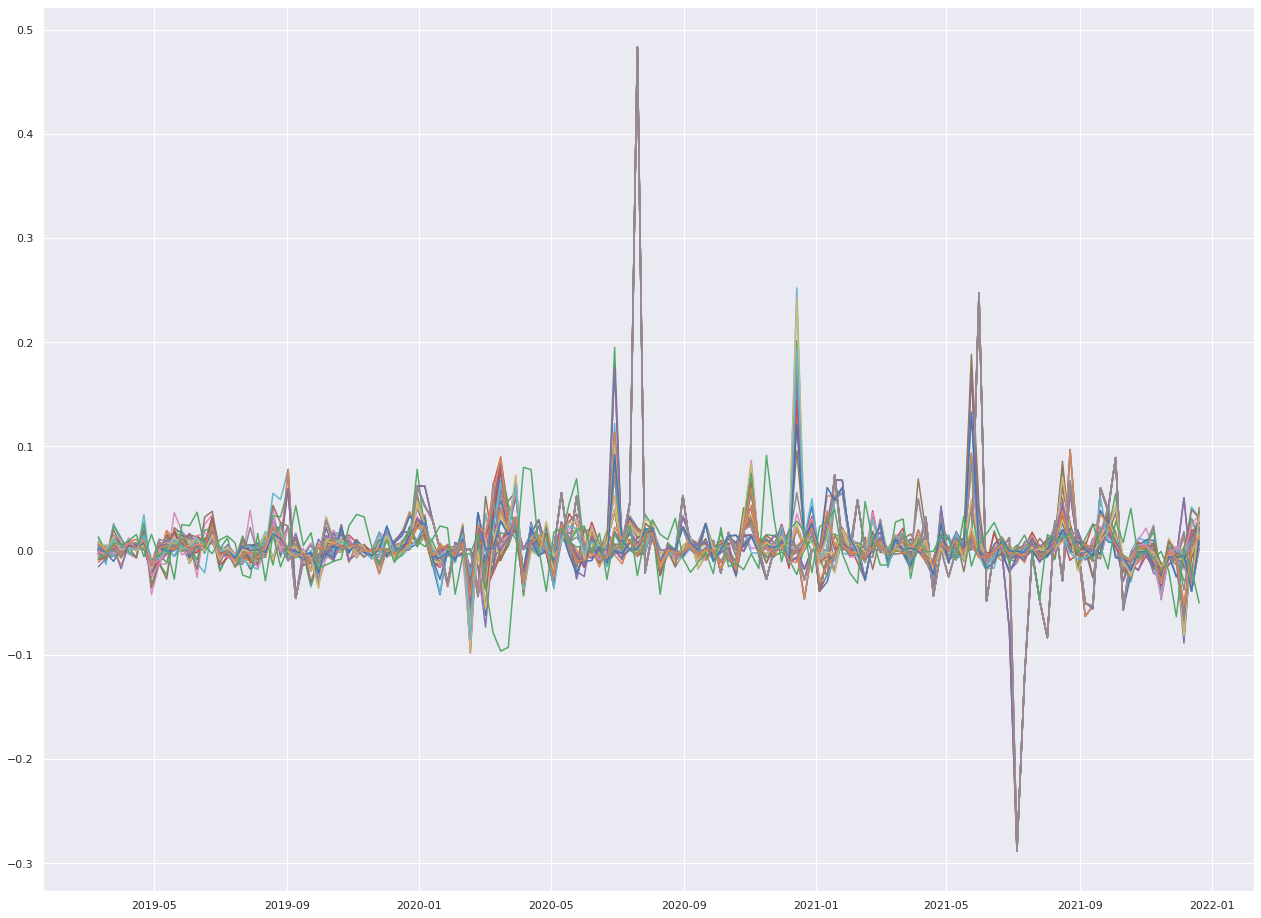

In [ ]:
plt.plot(port_res_no_risk)
plt.show()

In [ ]:
data_train = selected_ticker.copy()#[selected_ticker['rank'] < 262]
data_train, model, X_col, y_col, model_type, train_type, split_rank,  prob, feature_importance = training_setting[1]

In [ ]:
training_setting = [ 
                    [data_train, SGDRegressor(penalty= 'elasticnet',
                                                   alpha = 0.01,
                                                   l1_ratio = 0.25, random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, False],
                    
                    [data_train, AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=5),
                                                   learning_rate= 0.001,
                                                   loss = 'linear',
                                                   n_estimators=100, random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, True],
                    [data_train, RandomForestRegressor(max_depth = 10,
                                                       max_features = 'sqrt',
                                                       n_estimators = 200,
                                                       criterion = "squared_error", random_state=42), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, True],
                    [data_train, SVR(kernel = 'rbf',
                                     gamma = 1,
                                     C = 0.1), X_col_diff, 'Close_diff' , 'reg', 'simple', split_rank, False, False],
                    ]
data_train = selected_ticker.copy()#[selected_ticker['rank'] < 262]
data_train, model, X_col, y_col, model_type, train_type, split_rank,  prob, feature_importance = training_setting[1]
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
data_train[X_col] = min_max_scaler.transform(data_train[X_col])
standard_scaler = StandardScaler()
standard_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
data_train[X_col] = standard_scaler.transform(data_train[X_col])

X_train = data_train[data_train['rank'] < split_rank][X_col]
X_test = data_train[data_train['rank'] >= split_rank][X_col]
y_train = data_train[data_train['rank'] < split_rank][y_col]
y_test = data_train[data_train['rank'] >= split_rank][y_col] 
clf = model
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  learning_rate=0.001, n_estimators=100, random_state=42)

In [ ]:
mape

[("SGDRegressor(alpha=0.01, l1_ratio=0.25, penalty='elasticnet', random_state=42)_Close_pct",
  0.02300256536192766),
 ('AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),\n                  learning_rate=0.001, n_estimators=100, random_state=42)_Close_pct',
  0.023062539857880062),
 ("RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,\n                      random_state=42)_Close_pct",
  0.02373314019094692),
 ("SVR(C=0.1, gamma=0.001, kernel='sigmoid')_Close_pct", 0.023807772694867575)]

In [ ]:
j = 2
test_res = pd.DataFrame(close_pct_all[['Date', 'Close_'+mape[j][0], 'ticker']])
test_res_ret = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'Close_'+mape[j][0])
#если хотим учитывать ошибку
# test_res = test_res.merge(validation_errors[mape[j][0].split('(')[0]], left_on = 'ticker', right_index=True)
# test_res['Close_'+mape[j][0]] = test_res['Close_'+mape[j][0]]/ test_res[mape[j][0].split('(')[0]]

test_res['pred_pos'] = test_res['Close_'+mape[j][0]].clip(0).replace(0, np.nan)
test_res['rank'] = test_res.groupby('Date')['pred_pos'].rank(method = 'min')
test_res = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'rank', dropna = False)

test_res[10:]

ticker,AFLT,AKRN,ALRS,BANE,CHMF,GAZP,GMKN,KOGK,LKOH,LNZL,...,PIKK,PLZL,RASP,ROSN,RTKM,SBER,SIBN,SNGS,TATN,VSMO
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-18,12.0,9.0,3.0,6.0,5.0,8.0,21.0,NaN,18.0,NaN,...,15.0,16.0,24.0,17.0,7.0,NaN,22.0,26.0,4.0,10.0
2019-03-25,15.0,19.0,25.0,9.0,14.0,20.0,2.0,18.0,12.0,29.0,...,6.0,8.0,30.0,11.0,17.0,1.0,6.0,27.0,9.0,3.0
2019-04-01,4.0,22.0,21.0,12.0,10.0,25.0,5.0,26.0,15.0,7.0,...,8.0,17.0,29.0,14.0,2.0,1.0,11.0,27.0,12.0,9.0
2019-04-08,13.0,4.0,13.0,8.0,9.0,19.0,5.0,2.0,11.0,24.0,...,30.0,28.0,3.0,20.0,17.0,1.0,18.0,29.0,10.0,26.0
2019-04-15,18.0,27.0,19.0,10.0,15.0,14.0,17.0,6.0,16.0,2.0,...,3.0,28.0,4.0,8.0,22.0,1.0,7.0,30.0,9.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,14.0,1.0,16.0,11.0,4.0,12.0,9.0,2.0,20.0,7.0,...,29.0,25.0,22.0,18.0,28.0,21.0,5.0,24.0,26.0,8.0
2021-12-06,NaN,19.0,5.0,11.0,7.0,NaN,3.0,17.0,2.0,13.0,...,18.0,NaN,15.0,10.0,9.0,NaN,14.0,21.0,1.0,20.0
2021-12-13,24.0,1.0,11.0,23.0,12.0,3.0,9.0,2.0,7.0,26.0,...,10.0,28.0,18.0,22.0,13.0,27.0,15.0,29.0,6.0,4.0


In [ ]:
all_weights = all_weights_no_risk.copy()
i = 'SVR ledoit_wolf_constant_variance 30'
we = all_weights[i]
a = pd.DataFrame(columns = list(set(selected_ticker['ticker'].values)))
for j in list(we.keys()):
  a = a.append(we[j], ignore_index = True)
a.fillna(float(0), inplace = True)
a['ruonia'] = 1 - a.sum(axis = 1)
a

,MOEX,VSMO,MVID,GMKN,TATN,BANE,MTLR,NLMK,SNGS,ROSN,...,PIKK,ALRS,AFLT,GAZP,RTKM,SBER,MGNT,AKRN,LKOH,ruonia
0,0.07432,0.09362,0.00000,0.06175,0.00000,0.00000,0.00000,0.07143,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.11643,0.09946,-1.000000e-05
1,0.07083,0.05349,0.07526,0.05234,0.03151,0.05642,0.03019,0.05949,0.02248,0.04544,...,0.05053,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.07737,2.220446e-16
2,0.00000,0.06121,0.00000,0.04811,0.03306,0.00000,0.00000,0.09284,0.00000,0.08893,...,0.08334,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.10937,1.000000e-05
3,0.05331,0.04103,0.00000,0.03745,0.00000,0.05338,0.00000,0.06385,0.00000,0.05347,...,0.05029,0.02288,0.00000,0.01755,0.05346,0.04653,0.0,0.04673,0.08426,0.000000e+00
4,0.00000,0.03885,0.00000,0.03277,0.00000,0.04972,0.00000,0.06221,0.01936,0.05106,...,0.04369,0.00000,0.00000,0.02279,0.05326,0.04712,0.0,0.05092,0.07087,1.000000e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44993,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.000000e+00
142,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.05479,0.00000,0.03333,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.10005,0.00000,1.000000e-05
143,0.00000,0.09447,0.00000,0.00000,0.00000,0.00000,0.05940,0.15226,0.00000,0.00000,...,0.10824,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.06228,0.00000,1.000000e-05
144,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.000000e+00


In [ ]:
a - b

,AFLT,AKRN,ALRS,BANE,CHMF,GAZP,GMKN,KOGK,LKOH,LNZL,...,PLZL,RASP,ROSN,RTKM,SBER,SIBN,SNGS,TATN,VSMO,ruonia
0,-0.03370,0.07120,-0.02174,-0.03703,0.05892,-0.03621,0.02304,0.01604,0.04088,-0.00762,...,-0.01605,0.02305,-0.03531,-0.04236,-0.04990,-0.00262,0.00000,-0.01655,0.05999,NaN
1,-0.03833,-0.03023,-0.02238,0.01899,0.00441,-0.02837,0.01010,0.01776,0.01799,0.00752,...,0.01103,0.00681,0.00987,-0.04402,-0.05213,-0.01589,0.01889,0.01338,0.02193,NaN
2,-0.03395,-0.03247,-0.01264,-0.04061,0.03181,-0.02515,0.01647,0.00000,0.03890,-0.00371,...,0.03216,0.01845,0.04631,-0.04749,-0.06092,-0.01836,-0.00116,0.01802,0.03381,NaN
3,-0.03174,0.00980,0.00297,0.01253,-0.00029,0.00272,0.00915,0.00000,0.01726,0.00842,...,0.01165,0.01130,0.01448,0.01258,0.00836,-0.02732,-0.01209,-0.01515,0.01074,NaN
4,-0.03192,0.01184,-0.02192,0.01117,0.01294,0.00791,0.00494,0.00000,0.01218,0.00334,...,0.01042,0.00639,0.00959,0.00869,0.00452,0.01314,0.00878,-0.01903,0.00887,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,-0.04493,-0.03062,-0.03967,-0.03267,-0.04430,-0.04757,-0.04840,-0.01593,-0.03864,-0.03742,...,0.53702,-0.02557,-0.03001,-0.04033,-0.00377,-0.02239,-0.00607,-0.00933,-0.04002,NaN
142,-0.04452,0.06240,-0.02856,-0.03810,0.07183,-0.03132,-0.04464,0.06198,-0.03098,0.05701,...,0.04673,0.04898,-0.02278,-0.03861,0.00000,0.10160,0.02836,0.00000,-0.04426,NaN
143,-0.04533,0.02544,-0.02451,-0.04032,0.06864,-0.03451,-0.04463,0.01222,-0.03170,0.05151,...,0.03184,0.05699,-0.02074,-0.03837,0.00000,0.06562,-0.00658,0.00000,0.04351,NaN
144,-0.03512,-0.06954,-0.00649,-0.04301,-0.05804,-0.02210,-0.04389,-0.02891,-0.03293,-0.06005,...,-0.01604,-0.01635,-0.01625,-0.03209,-0.01911,-0.02263,-0.00082,-0.00575,-0.04538,NaN


In [ ]:
all_weights = all_weights_no_risk.copy()
i = 'ledoit_wolf_constant_variance all'
we = all_weights[i]
b = pd.DataFrame(columns = list(set(selected_ticker['ticker'].values)))
for j in list(we.keys()):
  b = b.append(we[j], ignore_index = True)
b.fillna(float(0), inplace = True)
b

,MOEX,VSMO,MVID,GMKN,TATN,BANE,MTLR,NLMK,SNGS,ROSN,...,KOGK,PIKK,ALRS,AFLT,GAZP,RTKM,SBER,MGNT,AKRN,LKOH
0,0.02649,0.03624,0.05864,0.03415,0.01432,0.04082,0.00000,0.03877,0.00000,0.03413,...,0.00000,0.06872,0.02151,0.03602,0.03870,0.04311,0.04548,0.01895,0.05084,0.05628
1,0.03526,0.03365,0.05742,0.03900,0.01710,0.04119,0.00352,0.04816,0.00508,0.03546,...,0.00000,0.03849,0.02179,0.04016,0.03107,0.04459,0.04719,0.04149,0.03343,0.05918
2,0.03353,0.03056,0.06351,0.02736,0.01542,0.04491,0.00000,0.05567,0.00488,0.04201,...,0.00000,0.04516,0.01312,0.03619,0.02853,0.04739,0.05423,0.03486,0.03649,0.06797
3,0.04188,0.03241,0.06053,0.02447,0.01918,0.04345,0.00000,0.05205,0.01354,0.03787,...,0.00000,0.03967,0.01908,0.03256,0.01664,0.04062,0.03105,0.03167,0.03970,0.06512
4,0.04223,0.03191,0.06124,0.02404,0.02233,0.04163,0.00000,0.04742,0.01244,0.03968,...,0.00000,0.03746,0.02032,0.03276,0.01689,0.04271,0.03480,0.03167,0.04088,0.05882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.01259,0.03711,0.02983,0.04822,0.00918,0.03308,0.00145,0.06933,0.00378,0.02854,...,0.01077,0.04347,0.04034,0.04371,0.04702,0.04163,0.00328,0.04539,0.03146,0.03865
142,0.00335,0.04160,0.02477,0.04559,0.00000,0.03777,0.01421,0.07124,0.00243,0.02110,...,0.01459,0.04471,0.02913,0.04312,0.03009,0.03991,0.00000,0.05202,0.04011,0.03080
143,0.00000,0.04924,0.01930,0.04507,0.00000,0.04030,0.01780,0.07402,0.00395,0.01812,...,0.00897,0.03177,0.02419,0.04378,0.03367,0.03946,0.00000,0.05706,0.03962,0.03126
144,0.00000,0.04126,0.01993,0.04372,0.00545,0.04352,0.02749,0.07562,0.00000,0.01479,...,0.02214,0.02258,0.00522,0.03478,0.02251,0.03293,0.01887,0.06323,0.07176,0.03259


In [ ]:
b.sum(axis = 0)

MOEX     7.14008
VSMO     6.96857
MVID     6.53173
GMKN     2.83827
TATN     2.21762
BANE     6.28995
MTLR     2.40832
NLMK     4.24334
SNGS     3.14782
ROSN     4.19960
CHMF     5.41033
PLZL     4.95129
LSRG     6.29859
LNZL     6.47359
PHOR     7.19315
SIBN     3.40081
NVTK     2.43211
MAGN     3.46454
MTSS     5.44998
RASP     4.30180
KOGK     5.56624
PIKK     5.32285
ALRS     3.42695
AFLT     5.24204
GAZP     2.19304
RTKM     6.61041
SBER     3.24332
MGNT     4.21505
AKRN    11.12430
LKOH     3.69433
dtype: float64

In [ ]:
all_weights = all_weights_no_risk.copy()
i = 'RandomForestRegressor exp_cov 5'
we = all_weights[i]
c= pd.DataFrame(columns = list(set(selected_ticker['ticker'].values)))
for j in list(we.keys()):
  c = c.append(we[j], ignore_index = True)
c.fillna(float(0), inplace = True)
c['ruonia'] = 1 - c.sum(axis = 1)
c

,MOEX,VSMO,MVID,GMKN,TATN,BANE,MTLR,NLMK,SNGS,ROSN,...,PIKK,ALRS,AFLT,GAZP,RTKM,SBER,MGNT,AKRN,LKOH,ruonia
0,0.00000,0.00000,0.0,0.00000,0.03746,0.0,0.00000,0.00000,0.00000,0.0,...,0.00000,0.23218,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.000000e+00
1,0.00000,0.29343,0.0,0.27139,0.00000,0.0,0.00000,0.16148,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.05545,0.0,0.00000,0.00000,-2.220446e-16
2,0.10862,0.00000,0.0,0.29965,0.00000,0.0,0.00000,0.00000,0.00000,0.0,...,0.00000,0.00000,0.11067,0.00000,0.28338,0.19768,0.0,0.00000,0.00000,-2.220446e-16
3,0.00000,0.00000,0.0,0.25835,0.00000,0.0,0.00000,0.00000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.24123,0.0,0.36228,0.00000,1.000000e-05
4,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.17657,0.00000,0.00000,0.0,...,0.26688,0.00000,0.00000,0.00000,0.00000,0.27246,0.0,0.00000,0.00000,-1.000000e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.000000e+00
142,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,...,0.00000,0.89152,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.10848,0.000000e+00
143,0.00000,0.07382,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.46037,0.00000,0.00000,0.0,0.00234,0.00000,3.000000e-05
144,0.00000,0.06713,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.000000e+00


In [ ]:
all_weights = all_weights_risk.copy()
i = 'RandomForestRegressor exp_cov 5'
we = all_weights[i]
d= pd.DataFrame(columns = list(set(selected_ticker['ticker'].values)))
for j in list(we.keys()):
  d = d.append(we[j], ignore_index = True)
d.fillna(float(0), inplace = True)
d['ruonia'] = 1 - d.sum(axis = 1)
d

,MOEX,VSMO,MVID,GMKN,TATN,BANE,MTLR,NLMK,SNGS,ROSN,...,PIKK,ALRS,AFLT,GAZP,RTKM,SBER,MGNT,AKRN,LKOH,ruonia
0,0.0,0.0,0.0,0.0,0.10236,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.43365,0.00000,0.0,0.0,0.00000,0.0,0.0,0.00000,-0.00001
1,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.70295,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000
2,0.0,0.0,0.0,0.0,0.00181,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.54242,0.0,0.0,0.05926,0.0,0.0,0.00000,0.00000
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.17034,0.0,0.0,0.0,...,0.0,0.00000,0.35964,0.0,0.0,0.04039,0.0,0.0,0.00000,0.00001
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.13377,0.0,0.0,0.0,...,0.0,0.00000,0.18420,0.0,0.0,0.23937,0.0,0.0,0.00000,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.78260,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00001
142,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.89152,0.00000,0.0,0.0,0.00000,0.0,0.0,0.10848,0.00000
143,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.70841,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000
144,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.88478,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000


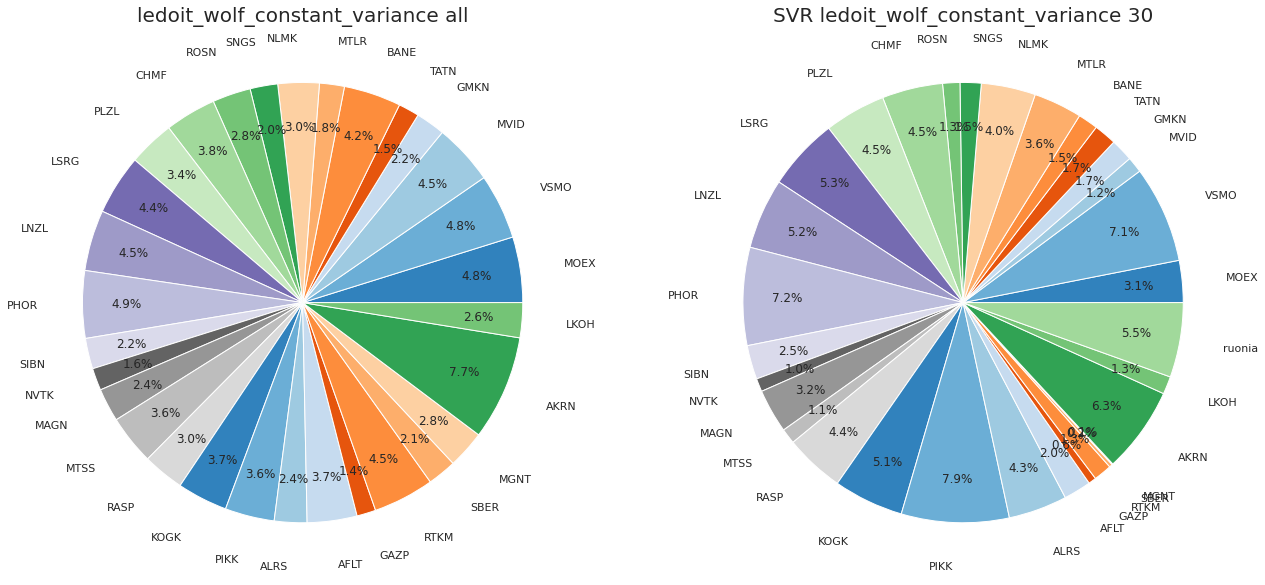

In [ ]:
from seaborn.palettes import color_palette
colors = sns.color_palette('tab20c')
sns.set(rc={'figure.figsize':(21.7,16.27)})
fig, ax = plt.subplots(ncols = 2,)
ax[0].pie(b.loc[:, (b != 0).any(axis=0)].mean(axis=0).values, labels = b.loc[:, (b != 0).any(axis=0)].mean(axis=0).index, autopct='%.1f%%', colors = colors, pctdistance =0.8, labeldistance = 1.2)
ax[1].pie(a.loc[:, (a != 0).any(axis=0)].mean(axis=0).values, labels = a.loc[:, (a != 0).any(axis=0)].mean(axis=0).index, autopct='%.1f%%', colors = colors, pctdistance =0.8, labeldistance = 1.2)
ax[0].set_title('ledoit_wolf_constant_variance all', fontsize = 20)
ax[1].set_title('SVR ledoit_wolf_constant_variance 30', fontsize = 20)
from google.colab import files
# plt.savefig("abc.png")
# files.download("abc.png") 
plt.show()

In [ ]:
close_pct_all.groupby('ticker').sum().sort_values('Close_pct')['Close_pct']

ticker
AFLT   -0.272788
BANE   -0.179077
TATN    0.016451
LSRG    0.070268
KOGK    0.165209
RTKM    0.298103
MVID    0.392173
ALRS    0.402789
LKOH    0.448500
MTSS    0.489230
SIBN    0.497026
ROSN    0.504301
MGNT    0.518912
SBER    0.620792
MAGN    0.623144
NVTK    0.623967
CHMF    0.627287
SNGS    0.633538
NLMK    0.643197
GMKN    0.651121
MOEX    0.653791
GAZP    0.844858
AKRN    0.881127
LNZL    0.882880
PHOR    0.907303
MTLR    0.932523
VSMO    0.985944
PLZL    1.091791
PIKK    1.198752
RASP    1.504909
Name: Close_pct, dtype: float64

In [ ]:
close_all

,Date,Close_1,Close,Close_pct,Close_diff,ticker,Close_pct_1,Close_diff_1,"Close_SGDRegressor(alpha=0.01, l1_ratio=0.25, penalty='elasticnet', random_state=42)_Close_pct","Close_AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),\n learning_rate=0.001, n_estimators=100, random_state=42)_Close_pct","Close_RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,\n random_state=42)_Close_pct","Close_SVR(C=0.1, gamma=0.001, kernel='sigmoid')_Close_pct"
0,2019-01-07,133.8853,137.4453,0.026590,3.56,AFLT,-0.000597,-0.08,134.216345,134.321103,134.479654,134.584110
1,2019-01-14,137.4453,139.7853,0.017025,2.34,AFLT,0.026590,3.56,137.669394,137.892691,137.943774,138.271540
2,2019-01-21,139.7853,138.4853,-0.009300,-1.30,AFLT,0.017025,2.34,140.013209,140.240308,140.437051,140.796571
3,2019-01-28,138.4853,138.0053,-0.003466,-0.48,AFLT,-0.009300,-1.30,138.767467,138.936077,139.130955,138.872725
4,2019-02-04,138.0053,134.6853,-0.024057,-3.32,AFLT,-0.003466,-0.48,138.307501,138.452436,138.565238,137.999785
...,...,...,...,...,...,...,...,...,...,...,...,...
4675,2021-11-29,51647.8300,51447.8300,-0.003872,-200.00,VSMO,-0.008447,-440.00,51742.014577,51815.946286,51870.932750,51221.521491
4676,2021-12-06,51447.8300,50027.8300,-0.027601,-1420.00,VSMO,-0.003872,-200.00,51550.397220,51593.728037,51751.350194,51509.520827
4677,2021-12-13,50027.8300,54067.8300,0.080755,4040.00,VSMO,-0.027601,-1420.00,50189.913984,50190.673105,50189.262399,50822.038612
4678,2021-12-20,54067.8300,52027.8300,-0.037730,-2040.00,VSMO,0.080755,4040.00,54146.451951,54243.823508,54140.104443,53125.189747


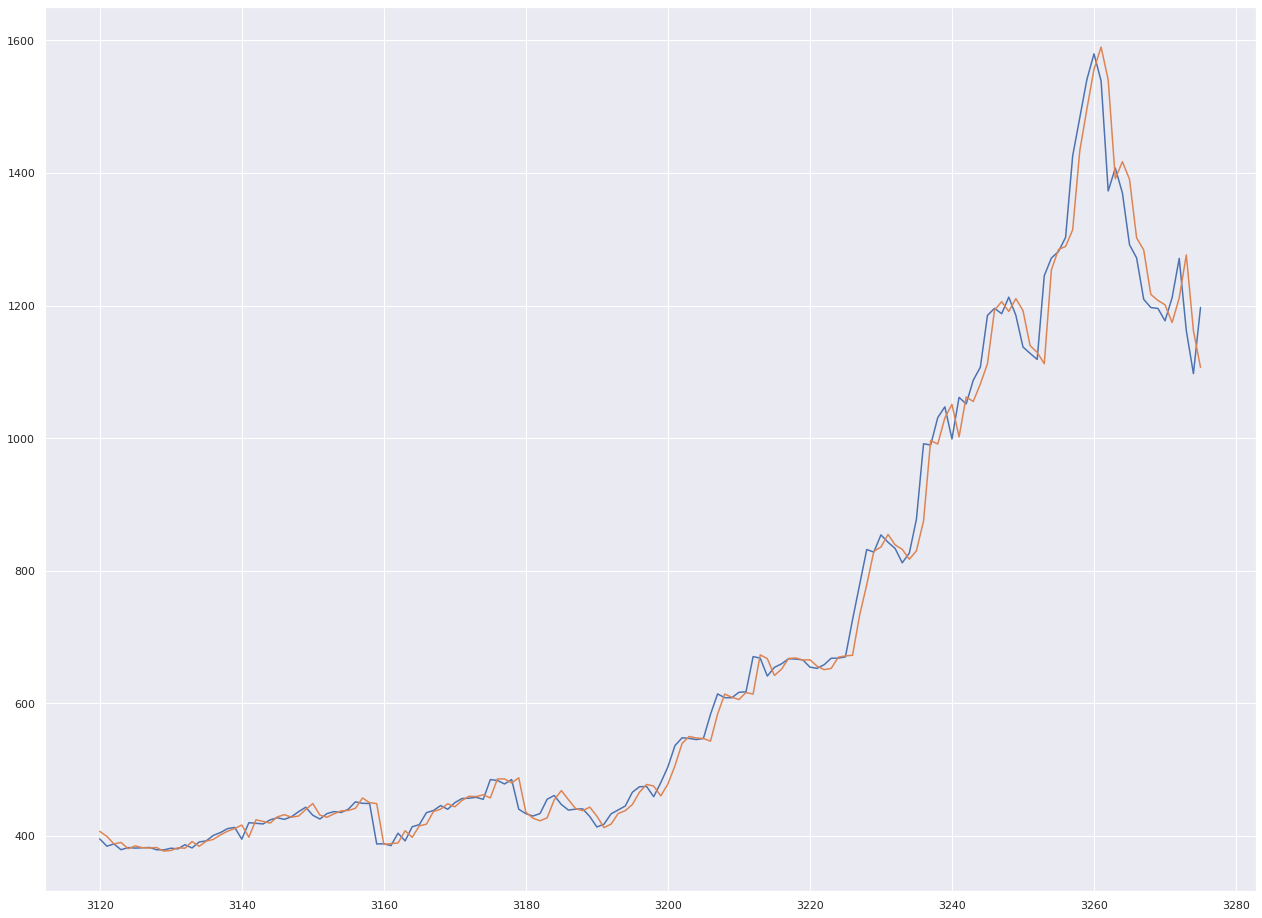

In [ ]:
plt.plot(close_all[close_all['ticker'] =='PIKK']['Close'])
plt.plot(close_all[close_all['ticker'] =='PIKK']["Close_SVR(C=0.1, gamma=0.001, kernel='sigmoid')_Close_pct"])
plt.show()

In [ ]:
close_pct_all.columns

Index(['Date', 'Close_1', 'Close', 'Close_pct', 'Close_diff', 'ticker',
       'Close_pct_1', 'Close_diff_1',
       'Close_SGDRegressor(alpha=0.01, l1_ratio=0.25, penalty='elasticnet', random_state=42)_Close_pct',
       'Close_AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),\n                  learning_rate=0.001, n_estimators=100, random_state=42)_Close_pct',
       'Close_RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,\n                      random_state=42)_Close_pct',
       'Close_SVR(C=0.1, gamma=0.001, kernel='sigmoid')_Close_pct'],
      dtype='object')

In [ ]:
port_res.columns[:-1]

Index(['SVR sample_cov 5', 'SVR sample_cov 10', 'SVR sample_cov 30',
       'SGDRegressor sample_cov 5', 'SGDRegressor sample_cov 10',
       'SGDRegressor sample_cov 30', 'AdaBoostRegressor sample_cov 5',
       'AdaBoostRegressor sample_cov 10', 'AdaBoostRegressor sample_cov 30',
       'RandomForestRegressor sample_cov 5',
       'RandomForestRegressor sample_cov 10',
       'RandomForestRegressor sample_cov 30', 'sample_cov all',
       'SVR exp_cov 5', 'SVR exp_cov 10', 'SVR exp_cov 30',
       'SGDRegressor exp_cov 5', 'SGDRegressor exp_cov 10',
       'SGDRegressor exp_cov 30', 'AdaBoostRegressor exp_cov 5',
       'AdaBoostRegressor exp_cov 10', 'AdaBoostRegressor exp_cov 30',
       'RandomForestRegressor exp_cov 5', 'RandomForestRegressor exp_cov 10',
       'RandomForestRegressor exp_cov 30', 'exp_cov all',
       'SVR ledoit_wolf_constant_variance 5',
       'SVR ledoit_wolf_constant_variance 10',
       'SVR ledoit_wolf_constant_variance 30',
       'SGDRegressor ledoit_wo

In [ ]:
port_res.index

DatetimeIndex(['2019-03-11', '2019-03-18', '2019-03-25', '2019-04-01',
               '2019-04-08', '2019-04-15', '2019-04-22', '2019-04-29',
               '2019-05-06', '2019-05-13',
               ...
               '2021-10-18', '2021-10-25', '2021-11-01', '2021-11-08',
               '2021-11-15', '2021-11-22', '2021-11-29', '2021-12-06',
               '2021-12-13', '2021-12-20'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=146, freq=None)

#####Итоги

In [ ]:
prev = selected_ticker[(selected_ticker['Date']>= port_res.index[0] - pd.DateOffset(7)) & (selected_ticker['Date'] <= port_res.index[-1] - pd.DateOffset(7))].pivot_table(index = 'Date',columns = 'ticker', values = 'Close')
new = selected_ticker[(selected_ticker['Date']>= port_res.index[0]) & (selected_ticker['Date'] <= port_res.index[-1])].pivot_table(index = 'Date',columns = 'ticker', values = 'Close')

In [ ]:
port_res = port_res_no_risk.copy()
all_weights = all_weights_no_risk.copy()

port_metrics = []
for i in tqdm(port_res.columns[:-1]):
  dohod = np.array(((port_res+1).cumprod()/(port_res+1).cumprod().iloc[0])[i])
  try:
    met = []
    met.append(i)
    met.append(i.split()[-2])
    met.append(i.split()[-3])
    met.append(i.split()[-1])
    met.append(np.round(total_volatility(port_res[i]), 5))
    met.append(np.round(total_return(dohod), 3))
    met.append(np.round(max_drawdown(dohod), 2))
    met.append(np.round(sharpe_ratio(dohod, ((rf+1).cumprod()/(rf+1).cumprod().iloc[0]).values, total_volatility(port_res[i])), 2))
  except:
    met = []
    met.append(i)
    met.append(i.split()[-2])
    met.append(' ')
    met.append(i.split()[-1])
    met.append(np.round(total_volatility(port_res[i]), 5))
    met.append(np.round(total_return(dohod), 3))
    met.append(np.round(max_drawdown(dohod), 2))
    met.append(np.round(sharpe_ratio(dohod, ((rf+1).cumprod()/(rf+1).cumprod().iloc[0]).values, total_volatility(port_res[i])), 2))
  #turnover
  we = all_weights[i]
  a = pd.DataFrame(columns = list(set(selected_ticker['ticker'].values)))
  for j in list(we.keys()):
    a = a.append(we[j], ignore_index = True)
  a.fillna(float(0), inplace = True)
  change = pd.DataFrame((np.array(new) - np.array(prev))/np.array(prev))
  new_weights = pd.DataFrame((np.array(change)*np.array(a)+np.array(a)).T/((np.array(change)*np.array(a)+np.array(a)).sum(axis = 1)+0.00000001).T).T
  turnover = np.abs(np.array(a)[1:] - np.array(new_weights[:-1])).sum()/np.array(a)[1:].shape[0]
  met.append(np.round(turnover,2))
  port_metrics.append(met)

dd = pd.DataFrame(port_metrics, columns = ['name', 'Cov_matrix', 'Model', 'Top_k', 'Total_volatility', 'Total_return', 'Max_drawdown', 'Sharpe_ratio', 'Turnover'])
dd

  0%|          | 0/52 [00:00<?, ?it/s]

,name,Cov_matrix,Model,Top_k,Total_volatility,Total_return,Max_drawdown,Sharpe_ratio,Turnover
0,SGDRegressor sample_cov 5,sample_cov,SGDRegressor,5,0.00028,0.354,8.29,11.07,1.38
1,SGDRegressor sample_cov 10,sample_cov,SGDRegressor,10,0.00025,0.125,12.38,-2.78,1.20
2,SGDRegressor sample_cov 30,sample_cov,SGDRegressor,30,0.00024,0.247,10.12,5.07,0.82
3,AdaBoostRegressor sample_cov 5,sample_cov,AdaBoostRegressor,5,0.00028,0.799,9.34,37.98,0.70
4,AdaBoostRegressor sample_cov 10,sample_cov,AdaBoostRegressor,10,0.00021,0.646,9.34,32.84,0.68
5,AdaBoostRegressor sample_cov 30,sample_cov,AdaBoostRegressor,30,0.00021,0.493,10.11,22.33,0.66
6,RandomForestRegressor sample_cov 5,sample_cov,RandomForestRegressor,5,0.00331,0.844,49.45,11.74,1.21
7,RandomForestRegressor sample_cov 10,sample_cov,RandomForestRegressor,10,0.00330,0.818,49.45,11.31,1.16
8,RandomForestRegressor sample_cov 30,sample_cov,RandomForestRegressor,30,0.00328,0.582,49.45,7.23,0.97
9,SVR sample_cov 5,sample_cov,SVR,5,0.00046,0.596,16.83,19.87,1.66


In [ ]:
dd[dd['Top_k'] == 'all'].groupby(['Cov_matrix']).median().groupby(['Cov_matrix']).median().to_latex(
    # index = False,
              caption = 'Медианные результаты в разрезе моделей (без учета риска)',
              label = 'tab:norisk_mod',
              position = 'h!')

'\\begin{table}[h!]\n\\centering\n\\caption{Медианные результаты в разрезе моделей (без учета риска)}\n\\label{tab:norisk_mod}\n\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  Total\\_volatility &  Total\\_return &  Max\\_drawdown &  Sharpe\\_ratio &  Turnover \\\\\nCov\\_matrix                       &                   &               &               &               &           \\\\\n\\midrule\nexp\\_cov                          &           0.00054 &         0.944 &         11.97 &         33.43 &      0.71 \\\\\nledoit\\_wolf\\_constant\\_correlation &           0.00024 &         0.559 &         10.59 &         25.29 &      0.47 \\\\\nledoit\\_wolf\\_constant\\_variance    &           0.00023 &         0.788 &         13.09 &         40.64 &      0.23 \\\\\nsample\\_cov                       &           0.00025 &         0.474 &         11.04 &         19.44 &      0.66 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [ ]:
dd.groupby(['Model', 'Top_k']).median()

Total_volatility  Total_return  Max_drawdown  \
Model                 Top_k                                                 
                      all            0.000245        0.6735        11.505   
AdaBoostRegressor     10             0.000220        0.6240        12.815   
                      30             0.000220        0.5955        12.800   
                      5              0.000255        0.7215        12.815   
RandomForestRegressor 10             0.003320        0.8075        49.585   
                      30             0.003315        0.6495        49.725   
                      5              0.003350        0.9215        49.585   
SGDRegressor          10             0.000250        0.2380        14.030   
                      30             0.000245        0.3150        12.840   
                      5              0.000255        0.4055         8.785   
SVR                   10             0.000950        1.6730        13.530   
                      30             0.000780        1.5455        12.745   
                      5              0.000470        0.7200        16.285   

                             Sharpe_ratio  Turnover  
Model                 Top_k                          
                      all          29.360     0.565  
AdaBoostRegressor     10           29.910     0.565  
                      30           27.310     0.545  
                      5            33.760     0.580  
RandomForestRegressor 10           11.110     1.145  
                      30            8.320     0.940  
                      5            13.010     1.210  
SGDRegressor          10            4.385     1.140  
                      30            9.420     0.730  
                      5            15.665     1.345  
SVR                   10           50.660     1.510  
                      30           46.690     1.245  
                      5            23.705     1.660

In [ ]:
dd[dd['Top_k'] == 'all'].groupby(['Cov_matrix']).median()

,Total_volatility,Total_return,Max_drawdown,Sharpe_ratio,Turnover
Cov_matrix,,,,,
exp_cov,0.00054,0.944,11.97,33.43,0.71
ledoit_wolf_constant_correlation,0.00024,0.559,10.59,25.29,0.47
ledoit_wolf_constant_variance,0.00023,0.788,13.09,40.64,0.23
sample_cov,0.00025,0.474,11.04,19.44,0.66


In [ ]:
dd[dd['Top_k'] == 'all'].groupby(['Cov_matrix']).median()

,Total_volatility,Total_return,Max_drawdown,Sharpe_ratio,Turnover
Cov_matrix,,,,,
exp_cov,0.00049,0.764,11.82,27.03,0.69
ledoit_wolf_constant_correlation,0.00025,0.573,10.49,25.78,0.47
ledoit_wolf_constant_variance,0.00023,0.785,13.16,40.35,0.23
sample_cov,0.00025,0.474,11.56,19.16,0.63


In [ ]:
i = 'index'
ruonia['week_ruo'] = ((1+ruonia['ruo'].values/100)**(1/(365/7)))-1
rf = ruonia[(ruonia['Date']>= port_res.index[0]) & (ruonia['Date'] <= port_res.index[-1])]['week_ruo']
((rf+1).cumprod()/(rf+1).cumprod().iloc[0])
port_res = port_res_risk.copy()
dohod = np.array(((port_res+1).cumprod()/(port_res+1).cumprod().iloc[0])[i])
met = []
met.append(np.round(total_volatility(port_res[i]), 5))
met.append(np.round(total_return(dohod), 5))
met.append(np.round(max_drawdown(dohod), 5))
met.append(np.round(sharpe_ratio(dohod, ((rf+1).cumprod()/(rf+1).cumprod().iloc[0]).values, total_volatility(port_res[i])), 5))
met

In [ ]:
fig = go.Figure()
for i in dd.sort_values('Sharpe_ratio', ascending = False)[:10]['name'].values:
  returns = pd.Series(port_res[i])
  fig.add_trace(go.Scatter(
                          x=list(returns.keys()),
                          y=(pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]),
                          name= i,
                          mode='lines',
                          # line=dict(width=1.5)
                          )
  
                )
returns = pd.Series(returns_all['index'])
fig.add_trace(go.Scatter(
                        x=list(returns.keys()),
                        y=(pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]),
                        name= 'index',
                        mode='lines+markers',
                        # line=dict(width=1.5)
                        )
              )
fig.update_layout(title='Total return ',
                  yaxis_title='Return',
                  xaxis_title = 'Date')
fig.update_layout(
    autosize=False,
    width=1800,
    height=900)
fig.show()

In [ ]:
1 - падение тоже было, но меньшую просадку активом стал PLZL
2 - RASP, PIKK сильно подняли портфель
3 - LNZL, PHOR и VSMO наиболие веса в портфеле в этот период

In [46]:
pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/ВКР/all_weights_no_risk.pkl')['SVR ledoit_wolf_constant_correlation 10']).T[114:117].dropna(axis =1,how = 'all')

,AKRN,CHMF,LKOH,LNZL,PHOR,RASP,VSMO,PIKK,PLZL,SNGS,NVTK,AFLT,MAGN,NLMK
2021-05-17,NaN,NaN,NaN,NaN,0.70731,NaN,0.29269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-24,NaN,0.0,NaN,0.46931,0.14999,0.0,0.07100,0.0,0.0,NaN,NaN,0.30970,0.0,0.0
2021-05-31,0.8543,0.0,0.01659,0.00000,NaN,NaN,0.03007,NaN,0.0,0.0,0.0,0.09905,NaN,0.0


In [ ]:
fig = go.Figure()
for i in dd.sort_values('Sharpe_ratio', ascending = False)[:20]['name'].values:
  returns = pd.Series(returns_all[i])
  fig.add_trace(go.Scatter(
                          x=list(returns.keys()),
                          y=(pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]),
                          name= i,
                          mode='lines',
                          # line=dict(width=1.5)
                          )
                )
returns = pd.Series(returns_all['index'])
fig.add_trace(go.Scatter(
                        x=list(returns.keys()),
                        y=(pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]),
                        name= 'index',
                        mode='lines+markers',
                        # line=dict(width=1.5)
                        )
              )
fig.update_layout(title='Total return ',
                  yaxis_title='Return',
                  xaxis_title = 'Date')
fig.update_layout(
    autosize=False,
    width=1800,
    height=900)
fig.show()

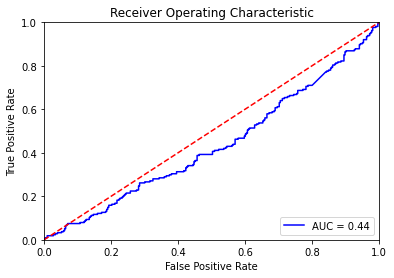

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(ee[ee['ticker'].isin(l[l.success_flg > 0.6].index)]['true'],
                                        ee[ee['ticker'].isin(l[l.success_flg > 0.6].index)]['prob'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#####EXTRA

In [ ]:
def train_pred(data_train,
                      model,
                      X_col,
                      y_col,
                      model_type = 'clf',
                      train_type = 'simple',
                      split_rank = 10,
                      prob = False,
                      feature_importance = False):
  output = dict()
  min_max_scaler = MinMaxScaler()
  min_max_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
  data_train[X_col] = min_max_scaler.transform(data_train[X_col])
  standard_scaler = StandardScaler()
  standard_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
  data_train[X_col] = standard_scaler.transform(data_train[X_col])

  X_train = data_train[data_train['rank'] < split_rank][X_col]
  X_test = data_train[data_train['rank'] >= split_rank][X_col]
  y_train = data_train[data_train['rank'] < split_rank][y_col]
  y_test = data_train[data_train['rank'] >= split_rank][y_col] 
  clf = model
  clf.fit(X_train, y_train)

In [ ]:
split_rank = 262
data_train = selected_ticker.copy()
training_setting = [ 
                    [data_train, SVR(kernel = 'sigmoid',
                                     gamma = 0.001,
                                     C = 0.1), X_col_pct, 'Close_pct' , 'reg', 'simple', split_rank, False, False]
                    ]

In [ ]:
training_setting[i]

[            Date ticker     Close      High      Open       Low        Volume  \
 0     2014-01-06   AFLT     82.83     84.83     83.96     82.10  9.531951e+08   
 1     2014-01-13   AFLT     84.25     99.30     83.25     82.09  2.430875e+09   
 2     2014-01-20   AFLT     78.70     86.20     84.25     76.02  2.472036e+09   
 3     2014-01-27   AFLT     83.00     84.86     77.70     77.70  1.435716e+09   
 4     2014-02-03   AFLT     79.50     83.98     83.53     75.00  2.108259e+09   
 ...          ...    ...       ...       ...       ...       ...           ...   
 12505 2021-11-29   VSMO  51447.83  52127.83  51887.83  49147.83  1.946880e+08   
 12506 2021-12-06   VSMO  50027.83  54327.83  51027.83  49887.83  2.653414e+08   
 12507 2021-12-13   VSMO  54067.83  54527.83  50547.83  50027.83  4.139013e+08   
 12508 2021-12-20   VSMO  52027.83  54327.83  54047.83  50427.83  1.664189e+08   
 12509 2021-12-27   VSMO  52927.83  54427.83  52467.83  51127.83  4.211534e+08   
 
        Divide

In [ ]:
split_rank = 262
all_results = pd.DataFrame(columns = ['Close_pct', 'Date', 'ticker'])
data_train = selected_ticker.copy()[selected_ticker['rank'] < 262]
close_all = selected_ticker.copy()[['Date', 'Close_1', 'Close', 'Close_pct','Close_diff', 'ticker', 'Close_pct_1', 'Close_diff_1']]
close_pct_all = selected_ticker.copy()[['Date', 'Close_1', 'Close', 'Close_pct','Close_diff', 'ticker','Close_pct_1', 'Close_diff_1']]

for j in tqdm(list(set(selected_ticker['ticker'].values))):
  data_train = selected_ticker.copy()[(selected_ticker['ticker'] == j)]
  for i in range(len(training_setting)):
    data_t, model, X_col, y_col, model_type, train_type, split_rk,  prob, feature_importance = training_setting[i]
    output = dict()
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
    data_train[X_col] = min_max_scaler.transform(data_train[X_col])
    standard_scaler = StandardScaler()
    standard_scaler.fit(data_train[data_train['rank'] < split_rank][X_col])
    data_train[X_col] = standard_scaler.transform(data_train[X_col])

    X_train = data_train[data_train['rank'] < split_rank][X_col]
    X_test = data_train[data_train['rank'] >= split_rank][X_col]
    y_train = data_train[data_train['rank'] < split_rank][y_col]
    y_test = data_train[data_train['rank'] >= split_rank][y_col] 
    clf = model
    clf.fit(X_train, y_train)
    itog = dict()
    itog['Close_pct'] =  clf.predict(X_test)
    itog['Date'] = data_train[data_train['rank'] >= split_rank]['Date'].values
    itog = pd.DataFrame(itog)
    itog['ticker'] = j


    all_results = pd.concat([all_results, itog])
all_results =pd.merge(all_results,selected_ticker.copy()[['Close_pct', 'ticker', 'Date', 'Close_1', 'Close']], how = 'left', on = ['ticker', 'Date'])
all_results['Close_pred'] = all_results['Close_1']*(1+all_results['Close_pct_x'])

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
mean_absolute_percentage_error(all_results['Close'], all_results['Close_pred'])

0.025161929742515413

In [ ]:
all_results

,Close_pct_x,Date,ticker,Close_pct_y,Close_1,Close,Close_pred
0,0.002366,2019-01-07,MOEX,0.035398,113.00,117.00,113.267333
1,0.000154,2019-01-14,MOEX,0.045556,117.00,122.33,117.017989
2,0.000232,2019-01-21,MOEX,-0.015041,122.33,120.49,122.358374
3,-0.000355,2019-01-28,MOEX,0.016682,120.49,122.50,120.447258
4,-0.001628,2019-02-04,MOEX,-0.022857,122.50,119.70,122.300564
...,...,...,...,...,...,...,...
4675,0.009041,2021-11-29,LKOH,0.031368,8464.00,8729.50,8540.521498
4676,0.007833,2021-12-06,LKOH,-0.002291,8729.50,8709.50,8797.877698
4677,0.005936,2021-12-13,LKOH,0.005798,8709.50,8760.00,8761.198799
4678,0.005886,2021-12-20,LKOH,-0.001884,8760.00,8743.50,8811.560547


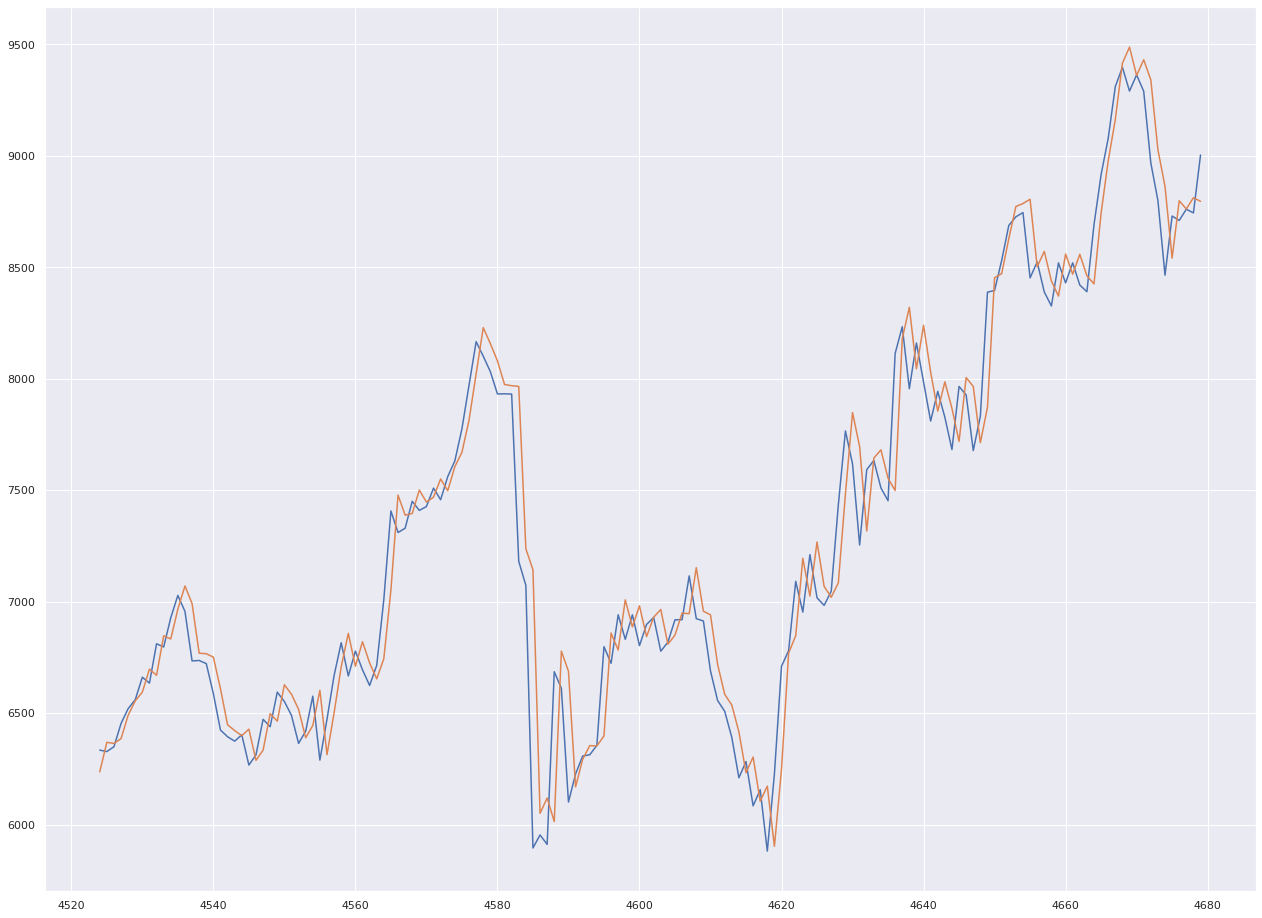

In [ ]:
l = 'LKOH'
plt.plot(all_results[all_results['ticker'] == l]['Close'])
plt.plot(all_results[all_results['ticker'] == l]['Close_pred'])

In [ ]:
res = all_results
all_mape = dict()
for i in tqdm(list(set(res['ticker'].values))):
  tick = dict()
  tick = mean_absolute_percentage_error(res[res['ticker'] == i]['Close'], res[res['ticker'] == i]['Close_pred'])
  all_mape[i] = tick 
validation_errors = pd.DataFrame(all_mape).T

  0%|          | 0/30 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
test_res = pd.DataFrame(all_results[['Date', 'Close_pct_x', 'ticker']])
test_res_ret = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'Close_pct_x')
test_res_ret
test_res['pred_pos'] = test_res['Close_pct_x'].clip(0).replace(0, np.nan)
test_res['rank'] = test_res.groupby('Date')['pred_pos'].rank(method = 'min')
test_res = test_res.pivot_table(index = 'Date',columns = 'ticker', values = 'rank', dropna = False)
test_res
i = 0
j = 0
top_k = 3
window = 10
bounds = (0,1)
cov_method = "ledoit_wolf_constant_variance"
return_method = "mean_historical_return"
all_weights = dict()
returns_all = dict()
fig = go.Figure()
plt.figure(figsize=(18, 12), dpi=80)

for top_k in tqdm((5,10,30)):
  returns = dict()
  w = dict()
  for i in range(test_res.shape[0]- window):
    ticker_need = list(test_res[test_res <= top_k ].iloc[i+window].dropna().index)
    start_rank = selected_ticker[selected_ticker['Date'] == test_res.iloc[i+window].name]['rank'].max() - window
    market = selected_ticker[(selected_ticker['rank'] >= start_rank) & (selected_ticker['rank'] < start_rank + window)].pivot_table(index = 'Date',columns = 'ticker', values = 'Close_pct')[ticker_need]
    market = test_res_ret[ticker_need].iloc[i:i+window] - market
    try:
      opt = weights(market, return_method, cov_method, bounds)
      current_date = selected_ticker[(selected_ticker['rank'] == start_rank + window -1)].Date.max()
      w[current_date] = opt
      pct_change  = np.array(selected_ticker[
                    (selected_ticker['rank'] >= start_rank + window -1) & (selected_ticker['rank'] <= start_rank + window)
                  ].pivot_table(index = 'Date',columns = 'ticker', values = 'Close')[ticker_need].pct_change().dropna())
      returns[current_date] = (pct_change*pd.DataFrame(pd.Series(opt)).T).sum(axis = 1)[0]
    except: #если ничего не будет расти, то инвестируем в руонию на неделю
      print(ticker_need, selected_ticker[(selected_ticker['rank'] == start_rank + window -1)].Date.max())
      current_date = selected_ticker[(selected_ticker['rank'] == start_rank + window -1)].Date.max()
      returns[current_date] = ((1+ruonia[ruonia["Date"] == test_res.iloc[i+window].name]['ruo_1'].values/100)**(1/(365/7)))[0]-1
      w[current_date] = dict()
  all_weights[str(top_k)] = w
  returns_all[str(top_k)] = returns
  fig.add_trace(go.Scatter(
                x=list(returns.keys()),
                y=(pd.Series(returns)+1).cumprod()/(1+pd.Series(returns)[0]),
                name= cov_method + str(top_k),
                mode='lines',
                # line=dict(width=1.5)
                )
      )
# returns_all['index'] = ((index[(index.TRADEDATE >= np.array(list(returns.keys())).min())  & (index.TRADEDATE <= np.array(list(returns.keys())).max())].set_index('TRADEDATE')['Close_index_pct_1'])).to_dict()
# fig.add_trace(go.Scatter(
#                 x=list(returns.keys()),
#                 y=(index[(index.TRADEDATE >= np.array(list(returns.keys())).min())
#                 & (index.TRADEDATE <= np.array(list(returns.keys())).max())].set_index('TRADEDATE')['Close_index_pct_1'] + 1).cumprod()/ (index[(index.TRADEDATE >= np.array(list(returns.keys())).min())
#                 & (index.TRADEDATE <= np.array(list(returns.keys())).max())].set_index('TRADEDATE')['Close_index_pct_1'] + 1)[0],
#                 name= 'index',
#                 mode='lines+markers',
#                 # line=dict(width=1.5)
#                 ))
fig.update_layout(title='Total return ',
                   yaxis_title='Return',
                  xaxis_title = 'Date')
fig.update_layout(
    autosize=False,
    width=1800,
    height=900,)
fig.show()






  0%|          | 0/3 [00:00<?, ?it/s]

<Figure size 1440x960 with 0 Axes>

In [ ]:
all_weights[str(top_k)] = w

In [ ]:
all_weights.keys()

dict_keys(['5', '10', '30'])

In [ ]:
port_res = pd.DataFrame([ i.values() for i in list(returns_all.values())]).T
port_res.index = returns_all[list(returns_all.keys())[0]].keys()
port_res.columns = returns_all.keys()
(port_res+1).cumprod()/(port_res+1).cumprod().iloc[0]
# ((1+ruonia['ruo'].values/100)**(1/(365/7)))[0]-1
ruonia['week_ruo'] = ((1+ruonia['ruo'].values/100)**(1/(365/7)))-1
rf = ruonia[(ruonia['Date']>= port_res.index[0]) & (ruonia['Date'] <= port_res.index[-1])]['week_ruo']
((rf+1).cumprod()/(rf+1).cumprod().iloc[0])
port_res

,5,10,30
2019-03-11,-0.001273,-0.006360,-0.004971
2019-03-18,0.005543,0.003359,0.004227
2019-03-25,0.006615,0.001647,0.003334
2019-04-01,-0.003415,-0.006369,-0.003954
2019-04-08,0.000254,0.004419,0.004478
...,...,...,...
2021-11-22,-0.001265,0.007937,0.009551
2021-11-29,-0.007644,-0.003077,-0.006090
2021-12-06,0.002308,-0.000175,0.007450
2021-12-13,0.010529,0.010903,0.014586


In [ ]:
prev = selected_ticker[(selected_ticker['Date']>= port_res.index[0] - pd.DateOffset(7)) & (selected_ticker['Date'] <= port_res.index[-1] - pd.DateOffset(7))].pivot_table(index = 'Date',columns = 'ticker', values = 'Close')
new = selected_ticker[(selected_ticker['Date']>= port_res.index[0]) & (selected_ticker['Date'] <= port_res.index[-1])].pivot_table(index = 'Date',columns = 'ticker', values = 'Close')

In [ ]:
# port_res = port_res_no_risk.copy()
# all_weights = all_weights_no_risk.copy()

port_metrics = []
for i in tqdm(port_res.columns[:]):
  dohod = np.array(((port_res+1).cumprod()/(port_res+1).cumprod().iloc[0])[i])
  try:
    met = []
    met.append(i)
    # met.append(i.split()[-2])
    # met.append(i.split()[-3])
    # met.append(i.split()[-1])
    met.append(np.round(total_volatility(port_res[i]), 5))
    met.append(np.round(total_return(dohod), 3))
    met.append(np.round(max_drawdown(dohod), 2))
    met.append(np.round(sharpe_ratio(dohod, ((rf+1).cumprod()/(rf+1).cumprod().iloc[0]).values, total_volatility(port_res[i])), 2))
  except:
    met = []
    met.append(i)
    # met.append(i.split()[-2])
    # met.append(' ')
    # met.append(i.split()[-1])
    met.append(np.round(total_volatility(port_res[i]), 5))
    met.append(np.round(total_return(dohod), 3))
    met.append(np.round(max_drawdown(dohod), 2))
    met.append(np.round(sharpe_ratio(dohod, ((rf+1).cumprod()/(rf+1).cumprod().iloc[0]).values, total_volatility(port_res[i])), 2))
  #turnover
  we = all_weights[i]
  a = pd.DataFrame(columns = list(set(selected_ticker['ticker'].values)))
  for j in list(we.keys()):
    a = a.append(we[j], ignore_index = True)
  a.fillna(float(0), inplace = True)
  change = pd.DataFrame((np.array(new) - np.array(prev))/np.array(prev))
  new_weights = pd.DataFrame((np.array(change)*np.array(a)+np.array(a)).T/((np.array(change)*np.array(a)+np.array(a)).sum(axis = 1)+0.00000001).T).T
  turnover = np.abs(np.array(a)[1:] - np.array(new_weights[:-1])).sum()/np.array(a)[1:].shape[0]
  met.append(np.round(turnover,2))
  port_metrics.append(met)

dd = pd.DataFrame(port_metrics, columns = [ 'Top_k', 'Total_volatility', 'Total_return', 'Max_drawdown', 'Sharpe_ratio', 'Turnover'])
dd

  0%|          | 0/3 [00:00<?, ?it/s]

,Top_k,Total_volatility,Total_return,Max_drawdown,Sharpe_ratio,Turnover
0,5,0.00049,0.435,22.76,12.06,0.64
1,10,0.00025,0.433,13.62,16.59,0.50
2,30,0.00027,0.935,7.17,46.47,0.34


In [ ]:
dd.to_latex(index= False)

'\\begin{tabular}{lrrrrr}\n\\toprule\nTop\\_k &  Total\\_volatility &  Total\\_return &  Max\\_drawdown &  Sharpe\\_ratio &  Turnover \\\\\n\\midrule\n    5 &           0.00049 &         0.435 &         22.76 &         12.06 &      0.64 \\\\\n   10 &           0.00025 &         0.433 &         13.62 &         16.59 &      0.50 \\\\\n   30 &           0.00027 &         0.935 &          7.17 &         46.47 &      0.34 \\\\\n\\bottomrule\n\\end{tabular}\n'